In [1]:
import os, re
import glob
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

In [2]:
class Preprocessor:
    def __init__(self, output_path):
        self.output_path = output_path
        self.output_file = None
        self.line_count = 0
        self.file_count = 0
        self.code_ident = ["((", "))", "{{", "}}",  "[[",  "]]",  "::", ":="]
        self.html_tags = ["<img", "<input type", "<p>", "<br>"]
        self.line_per_docsite = {} #number of lines in spec/website
        self.word_per_docsite = {} #number of words in spec/website
        self.line_per_spec = {} #number of lines per spec file
        self.spec_per_rel = {} #number of spec file per release
        
        
    def processAll(self, input_path):
        #input_path is a directory containing raw data
        
        self.file_count = 0
        output_file_path = os.path.join(self.output_path,'processed_5G.txt')
        
        if os.path.exists(output_file_path):
            with open(output_file_path, 'r') as fp:
                self.line_count = len(fp.readlines()) #To get the next sequence number, as we are appending
            
        self.output_file = open(output_file_path,'a')
        
        for file in glob.glob(input_path + '/**/*.txt', recursive=True):
            #if file.endswith(".txt"):
            file_path = os.path.join(input_path,file)
            self.processIt(file_path, [1])
            
        self.output_file.close()
    
    def processIt(self, file, task:list):
        
        #Count specs per release
        if file.split('/')[5][:3] == "Rel":
            key = file.split('/')[5]
            if key in self.spec_per_rel:
                self.spec_per_rel[key] += 1
            else:
                self.spec_per_rel[key] = 1
        
        isSpec = False
        section_at_next = True
        self.file_count += 1
        file_line_count = 0
        file_word_count = 0
        #file: path to a file
        with open(file) as f:
            text = f.readlines()
            for line in text:
                #print(line)
                
                if any(x in line for x in self.code_ident):
                    continue
                if any(x in line for x in self.html_tags):
                    continue
                if '\\' in line: #noisy data
                    continue
                #if 'Editor\'s Note' in line:
                #    continue
                if line.istitle(): #Title case: first letter of the first word capitalized- means it is a new sentence
                    self.output_file.write('\n')
                else: 
                    self.output_file.write(' ')
                line = re.sub(r'\[\d*?\]', '', line) #Citation removal
                line = re.sub(r'(as shown below|[Ss]ee figure below):*\-*', '', line) #remove certain strings
                line = re.sub('\(see [fF]igure .*?\d\)', '', line) #remove '(see Figure #)'
                line = re.sub('Figure .*?[\dA-Za-z]:', '', line) #Figure captions
                line = re.sub(r'(\d[A-Za-z]*\.)*\d[\.\-]\d?', '', line) #5.3.4.1 or 4.5.2-1 type number removal
                line = re.sub(r'\[pic\]', '', line) #picture alternative bad text removal
                #line = re.sub(r'\\+', '\\', line) #keep only one backslash
                line = re.sub(r'\\x[0-9a-fA-F]{2}', '', line) #removing '\xc#' type patterns
                
                
                line = re.sub(r'(\n)+', '', line) #remove extra newlines
                line = re.sub(r'(\t)+', ' ', line) #remove tabs
                line = re.sub(r'^[\.·\-]', '', line) #starting dot, interpunct, hyphen removal
                line = re.sub(r'^ ', '', line) #starting whitespace removal
                line = re.sub(r'[\.:,;\-]*$', '', line) #one or multiple dot, colon, hyphen, semicolon removal at the end
                line = re.sub(r'\|', '', line) #pipe generated from table
                line = re.sub(r' +', ' ', line) #multiple whitespace, keep one
                              
                if section_at_next is True:
                    line = re.sub(r'^\d.*', '', line) #remove lines with starting digits, meaning sections
                
                
                
                line = re.sub(r'([,;:])(\w)', r'\1 \2', line) #insert whitespace after punctuations, except fullstop, underscore
                                                              #hyphen
                line = re.sub(r'\ue000', '', line, re.UNICODE)
                
                
                
                line = re.sub(r'(\( )', '\(', line) #whitespace after opening paren.
                line = re.sub(r'( \))', '\)', line) #whitespace before closing paren.
                line = re.sub(r'(\(\))|(\[\])|(\{\})', '', line) #remove empty paren, curly-braces, brackets
                line = re.sub(r'^(TS \d\d\d?)|^(TR \d\d\d?)', 'Specification document', line)
                line = re.sub(r'(TS \d\d\d?)|(TR \d\d\d?)', 'specification document', line)
                
                if len(line.split()) < 4 : #skip the line
                    continue
                if sum(c.isdigit() for c in line)/len(line) >= 0.2: #More than 20% characters of the line are digits
                    continue
                if re.search(r'(C\(\d\d\d\))', line):
                    continue
                if re.search(r'% %', line):
                    continue
                if re.search(r'-?\d,? -?\d,? -?\d,? -?\d', line): #paterns like -1, 1, 1 1 etc.
                    continue
                if re.search(r'-?[A-Za-z],? -?[A-Za-z],? -?[A-Za-z]', line): #paterns like -1, 1, 1 1 etc.
                    continue
                
                if line[-2:] == 'TS' or line[:-2] == 'TR':
                    section_at_next = False
                else:
                    section_at_next = True
                    
                #line = line + '.'
                
                if line != '' and line != '.':
                    line_set = line.split('. ') #Some lines still have multiple sentences
                    for i, sentence in enumerate(line_set):
                        self.line_count += 1
                        file_line_count += 1
                        file_word_count += len(sentence.split())
                        if i != len(line_set)-1:
                            
                            self.output_file.write(sentence + '.\n')
                        else:
                            self.output_file.write(sentence)
            #end of document
            self.output_file.write('\n')
            print(str(self.file_count)+ " file(s) completed. Lines added: " + str(file_line_count))
            
            if file.split('/')[5][:3] == "Rel":
                key = 'spec'
                isSpec = True
            if file.split('/')[-4] == "Dataset_L1" or file.split('/')[5][:3] == 'web':
                key = file.split('/')[-2] #Name of the website
                isSpec = False
            if key in self.line_per_docsite:
                self.line_per_docsite[key] += file_line_count
            else:
                self.line_per_docsite[key] = file_line_count
                
            if key in self.word_per_docsite:
                self.word_per_docsite[key] += file_word_count
            else:
                self.word_per_docsite[key] = file_word_count
            
            if isSpec:
                key = file_line_count
                if key in self.line_per_spec:
                    self.line_per_spec[key] += 1
                else:
                    self.line_per_spec[key] = 1
            
            print("\n---------------------------------------------------------------------------------------------\n")
        #task is a list of preprocessing tasks you want to carry on
        
        

In [3]:
input_path = "/scratch/gilbreth/rahman75/raw_data/" #all inputs
input_path_2 = "/home/rahman75/Scrap/Dataset_L1"
#input_path = "/home/rahman75/Preprocessing/raw" #demo inputs
output_path = "/scratch/gilbreth/rahman75/gold_data"
#raw_data_path = ["spec","web"]


### Outputs

In [4]:
dataProcessor = Preprocessor(output_path)
dataProcessor.processAll(input_path)
dataProcessor.processAll(input_path_2)

1 file(s) completed. Lines added: 576

---------------------------------------------------------------------------------------------

2 file(s) completed. Lines added: 464

---------------------------------------------------------------------------------------------

3 file(s) completed. Lines added: 350

---------------------------------------------------------------------------------------------

4 file(s) completed. Lines added: 1576

---------------------------------------------------------------------------------------------

5 file(s) completed. Lines added: 402

---------------------------------------------------------------------------------------------

6 file(s) completed. Lines added: 186

---------------------------------------------------------------------------------------------

7 file(s) completed. Lines added: 244

---------------------------------------------------------------------------------------------

8 file(s) completed. Lines added: 7621

---------------------

64 file(s) completed. Lines added: 299

---------------------------------------------------------------------------------------------

65 file(s) completed. Lines added: 110

---------------------------------------------------------------------------------------------

66 file(s) completed. Lines added: 1528

---------------------------------------------------------------------------------------------

67 file(s) completed. Lines added: 520

---------------------------------------------------------------------------------------------

68 file(s) completed. Lines added: 180

---------------------------------------------------------------------------------------------

69 file(s) completed. Lines added: 176

---------------------------------------------------------------------------------------------

70 file(s) completed. Lines added: 473

---------------------------------------------------------------------------------------------

71 file(s) completed. Lines added: 351

--------------

125 file(s) completed. Lines added: 3875

---------------------------------------------------------------------------------------------

126 file(s) completed. Lines added: 4047

---------------------------------------------------------------------------------------------

127 file(s) completed. Lines added: 552

---------------------------------------------------------------------------------------------

128 file(s) completed. Lines added: 1712

---------------------------------------------------------------------------------------------

129 file(s) completed. Lines added: 665

---------------------------------------------------------------------------------------------

130 file(s) completed. Lines added: 928

---------------------------------------------------------------------------------------------

131 file(s) completed. Lines added: 4552

---------------------------------------------------------------------------------------------

132 file(s) completed. Lines added: 912

---

185 file(s) completed. Lines added: 5987

---------------------------------------------------------------------------------------------

186 file(s) completed. Lines added: 703

---------------------------------------------------------------------------------------------

187 file(s) completed. Lines added: 447

---------------------------------------------------------------------------------------------

188 file(s) completed. Lines added: 734

---------------------------------------------------------------------------------------------

189 file(s) completed. Lines added: 3263

---------------------------------------------------------------------------------------------

190 file(s) completed. Lines added: 593

---------------------------------------------------------------------------------------------

191 file(s) completed. Lines added: 2934

---------------------------------------------------------------------------------------------

192 file(s) completed. Lines added: 1060

---

246 file(s) completed. Lines added: 7637

---------------------------------------------------------------------------------------------

247 file(s) completed. Lines added: 559

---------------------------------------------------------------------------------------------

248 file(s) completed. Lines added: 88

---------------------------------------------------------------------------------------------

249 file(s) completed. Lines added: 570

---------------------------------------------------------------------------------------------

250 file(s) completed. Lines added: 2320

---------------------------------------------------------------------------------------------

251 file(s) completed. Lines added: 490

---------------------------------------------------------------------------------------------

252 file(s) completed. Lines added: 1468

---------------------------------------------------------------------------------------------

253 file(s) completed. Lines added: 313

-----

308 file(s) completed. Lines added: 606

---------------------------------------------------------------------------------------------

309 file(s) completed. Lines added: 2415

---------------------------------------------------------------------------------------------

310 file(s) completed. Lines added: 6175

---------------------------------------------------------------------------------------------

311 file(s) completed. Lines added: 812

---------------------------------------------------------------------------------------------

312 file(s) completed. Lines added: 89

---------------------------------------------------------------------------------------------

313 file(s) completed. Lines added: 4597

---------------------------------------------------------------------------------------------

314 file(s) completed. Lines added: 873

---------------------------------------------------------------------------------------------

315 file(s) completed. Lines added: 8183

----

369 file(s) completed. Lines added: 383

---------------------------------------------------------------------------------------------

370 file(s) completed. Lines added: 507

---------------------------------------------------------------------------------------------

371 file(s) completed. Lines added: 713

---------------------------------------------------------------------------------------------

372 file(s) completed. Lines added: 9083

---------------------------------------------------------------------------------------------

373 file(s) completed. Lines added: 6606

---------------------------------------------------------------------------------------------

374 file(s) completed. Lines added: 609

---------------------------------------------------------------------------------------------

375 file(s) completed. Lines added: 4638

---------------------------------------------------------------------------------------------

376 file(s) completed. Lines added: 620

----

430 file(s) completed. Lines added: 3111

---------------------------------------------------------------------------------------------

431 file(s) completed. Lines added: 105

---------------------------------------------------------------------------------------------

432 file(s) completed. Lines added: 216

---------------------------------------------------------------------------------------------

433 file(s) completed. Lines added: 974

---------------------------------------------------------------------------------------------

434 file(s) completed. Lines added: 788

---------------------------------------------------------------------------------------------

435 file(s) completed. Lines added: 829

---------------------------------------------------------------------------------------------

436 file(s) completed. Lines added: 135

---------------------------------------------------------------------------------------------

437 file(s) completed. Lines added: 1201

-----

494 file(s) completed. Lines added: 259

---------------------------------------------------------------------------------------------

495 file(s) completed. Lines added: 699

---------------------------------------------------------------------------------------------

496 file(s) completed. Lines added: 1049

---------------------------------------------------------------------------------------------

497 file(s) completed. Lines added: 610

---------------------------------------------------------------------------------------------

498 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

499 file(s) completed. Lines added: 3740

---------------------------------------------------------------------------------------------

500 file(s) completed. Lines added: 283

---------------------------------------------------------------------------------------------

501 file(s) completed. Lines added: 135

-----

555 file(s) completed. Lines added: 168

---------------------------------------------------------------------------------------------

556 file(s) completed. Lines added: 103

---------------------------------------------------------------------------------------------

557 file(s) completed. Lines added: 297

---------------------------------------------------------------------------------------------

558 file(s) completed. Lines added: 1743

---------------------------------------------------------------------------------------------

559 file(s) completed. Lines added: 115

---------------------------------------------------------------------------------------------

560 file(s) completed. Lines added: 164

---------------------------------------------------------------------------------------------

561 file(s) completed. Lines added: 953

---------------------------------------------------------------------------------------------

562 file(s) completed. Lines added: 1740

-----

617 file(s) completed. Lines added: 19412

---------------------------------------------------------------------------------------------

618 file(s) completed. Lines added: 3664

---------------------------------------------------------------------------------------------

619 file(s) completed. Lines added: 1727

---------------------------------------------------------------------------------------------

620 file(s) completed. Lines added: 90

---------------------------------------------------------------------------------------------

621 file(s) completed. Lines added: 577

---------------------------------------------------------------------------------------------

622 file(s) completed. Lines added: 5060

---------------------------------------------------------------------------------------------

623 file(s) completed. Lines added: 404

---------------------------------------------------------------------------------------------

624 file(s) completed. Lines added: 160

---

678 file(s) completed. Lines added: 1216

---------------------------------------------------------------------------------------------

679 file(s) completed. Lines added: 411

---------------------------------------------------------------------------------------------

680 file(s) completed. Lines added: 180

---------------------------------------------------------------------------------------------

681 file(s) completed. Lines added: 2630

---------------------------------------------------------------------------------------------

682 file(s) completed. Lines added: 441

---------------------------------------------------------------------------------------------

683 file(s) completed. Lines added: 738

---------------------------------------------------------------------------------------------

684 file(s) completed. Lines added: 4012

---------------------------------------------------------------------------------------------

685 file(s) completed. Lines added: 957

----

740 file(s) completed. Lines added: 114

---------------------------------------------------------------------------------------------

741 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

742 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

743 file(s) completed. Lines added: 10

---------------------------------------------------------------------------------------------

744 file(s) completed. Lines added: 128

---------------------------------------------------------------------------------------------

745 file(s) completed. Lines added: 147

---------------------------------------------------------------------------------------------

746 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

747 file(s) completed. Lines added: 3

----------------

806 file(s) completed. Lines added: 159

---------------------------------------------------------------------------------------------

807 file(s) completed. Lines added: 54

---------------------------------------------------------------------------------------------

808 file(s) completed. Lines added: 855

---------------------------------------------------------------------------------------------

809 file(s) completed. Lines added: 61

---------------------------------------------------------------------------------------------

810 file(s) completed. Lines added: 61

---------------------------------------------------------------------------------------------

811 file(s) completed. Lines added: 339

---------------------------------------------------------------------------------------------

812 file(s) completed. Lines added: 61

---------------------------------------------------------------------------------------------

813 file(s) completed. Lines added: 571

-----------

870 file(s) completed. Lines added: 183

---------------------------------------------------------------------------------------------

871 file(s) completed. Lines added: 377

---------------------------------------------------------------------------------------------

872 file(s) completed. Lines added: 354

---------------------------------------------------------------------------------------------

873 file(s) completed. Lines added: 92

---------------------------------------------------------------------------------------------

874 file(s) completed. Lines added: 93

---------------------------------------------------------------------------------------------

875 file(s) completed. Lines added: 101

---------------------------------------------------------------------------------------------

876 file(s) completed. Lines added: 461

---------------------------------------------------------------------------------------------

877 file(s) completed. Lines added: 250

---------

931 file(s) completed. Lines added: 3379

---------------------------------------------------------------------------------------------

932 file(s) completed. Lines added: 2284

---------------------------------------------------------------------------------------------

933 file(s) completed. Lines added: 857

---------------------------------------------------------------------------------------------

934 file(s) completed. Lines added: 560

---------------------------------------------------------------------------------------------

935 file(s) completed. Lines added: 62

---------------------------------------------------------------------------------------------

936 file(s) completed. Lines added: 924

---------------------------------------------------------------------------------------------

937 file(s) completed. Lines added: 62

---------------------------------------------------------------------------------------------

938 file(s) completed. Lines added: 136

-------

992 file(s) completed. Lines added: 766

---------------------------------------------------------------------------------------------

993 file(s) completed. Lines added: 730

---------------------------------------------------------------------------------------------

994 file(s) completed. Lines added: 118

---------------------------------------------------------------------------------------------

995 file(s) completed. Lines added: 95

---------------------------------------------------------------------------------------------

996 file(s) completed. Lines added: 55

---------------------------------------------------------------------------------------------

997 file(s) completed. Lines added: 105

---------------------------------------------------------------------------------------------

998 file(s) completed. Lines added: 2412

---------------------------------------------------------------------------------------------

999 file(s) completed. Lines added: 367

--------

1055 file(s) completed. Lines added: 927

---------------------------------------------------------------------------------------------

1056 file(s) completed. Lines added: 291

---------------------------------------------------------------------------------------------

1057 file(s) completed. Lines added: 1163

---------------------------------------------------------------------------------------------

1058 file(s) completed. Lines added: 506

---------------------------------------------------------------------------------------------

1059 file(s) completed. Lines added: 282

---------------------------------------------------------------------------------------------

1060 file(s) completed. Lines added: 283

---------------------------------------------------------------------------------------------

1061 file(s) completed. Lines added: 129

---------------------------------------------------------------------------------------------

1062 file(s) completed. Lines added: 530

1115 file(s) completed. Lines added: 4208

---------------------------------------------------------------------------------------------

1116 file(s) completed. Lines added: 1558

---------------------------------------------------------------------------------------------

1117 file(s) completed. Lines added: 784

---------------------------------------------------------------------------------------------

1118 file(s) completed. Lines added: 777

---------------------------------------------------------------------------------------------

1119 file(s) completed. Lines added: 1178

---------------------------------------------------------------------------------------------

1120 file(s) completed. Lines added: 1508

---------------------------------------------------------------------------------------------

1121 file(s) completed. Lines added: 405

---------------------------------------------------------------------------------------------

1122 file(s) completed. Lines added: 

1176 file(s) completed. Lines added: 2593

---------------------------------------------------------------------------------------------

1177 file(s) completed. Lines added: 421

---------------------------------------------------------------------------------------------

1178 file(s) completed. Lines added: 913

---------------------------------------------------------------------------------------------

1179 file(s) completed. Lines added: 3339

---------------------------------------------------------------------------------------------

1180 file(s) completed. Lines added: 3062

---------------------------------------------------------------------------------------------

1181 file(s) completed. Lines added: 533

---------------------------------------------------------------------------------------------

1182 file(s) completed. Lines added: 2804

---------------------------------------------------------------------------------------------

1183 file(s) completed. Lines added: 

1244 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1245 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

1246 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

1247 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1248 file(s) completed. Lines added: 10

---------------------------------------------------------------------------------------------

1249 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1250 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1251 file(s) completed. Lines added: 9

-------------

1308 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1309 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1310 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1311 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1312 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1313 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1314 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1315 file(s) completed. Lines added: 1

---------------

1377 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

1378 file(s) completed. Lines added: 13

---------------------------------------------------------------------------------------------

1379 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1380 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1381 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

1382 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1383 file(s) completed. Lines added: 20

---------------------------------------------------------------------------------------------

1384 file(s) completed. Lines added: 1

-------------

1448 file(s) completed. Lines added: 4

---------------------------------------------------------------------------------------------

1449 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1450 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1451 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1452 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1453 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1454 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1455 file(s) completed. Lines added: 0

---------------

1515 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1516 file(s) completed. Lines added: 14

---------------------------------------------------------------------------------------------

1517 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

1518 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1519 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1520 file(s) completed. Lines added: 8

---------------------------------------------------------------------------------------------

1521 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1522 file(s) completed. Lines added: 5

-------------

1592 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1593 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1594 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1595 file(s) completed. Lines added: 9

---------------------------------------------------------------------------------------------

1596 file(s) completed. Lines added: 9

---------------------------------------------------------------------------------------------

1597 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1598 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

1599 file(s) completed. Lines added: 0

---------------


1672 file(s) completed. Lines added: 29

---------------------------------------------------------------------------------------------

1673 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1674 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1675 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1676 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1677 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1678 file(s) completed. Lines added: 10

---------------------------------------------------------------------------------------------

1679 file(s) completed. Lines added: 21

-----------

1735 file(s) completed. Lines added: 15

---------------------------------------------------------------------------------------------

1736 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1737 file(s) completed. Lines added: 8

---------------------------------------------------------------------------------------------

1738 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

1739 file(s) completed. Lines added: 15

---------------------------------------------------------------------------------------------

1740 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1741 file(s) completed. Lines added: 12

---------------------------------------------------------------------------------------------

1742 file(s) completed. Lines added: 3

------------

1798 file(s) completed. Lines added: 15

---------------------------------------------------------------------------------------------

1799 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1800 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1801 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1802 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1803 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1804 file(s) completed. Lines added: 9

---------------------------------------------------------------------------------------------

1805 file(s) completed. Lines added: 1

--------------

1876 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1877 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

1878 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1879 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1880 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1881 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1882 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

1883 file(s) completed. Lines added: 2

---------------

1938 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1939 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1940 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

1941 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

1942 file(s) completed. Lines added: 22

---------------------------------------------------------------------------------------------

1943 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

1944 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

1945 file(s) completed. Lines added: 0

--------------

2020 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2021 file(s) completed. Lines added: 4

---------------------------------------------------------------------------------------------

2022 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

2023 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

2024 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2025 file(s) completed. Lines added: 7

---------------------------------------------------------------------------------------------

2026 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2027 file(s) completed. Lines added: 0

---------------

2084 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2085 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2086 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2087 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2088 file(s) completed. Lines added: 16

---------------------------------------------------------------------------------------------

2089 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

2090 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2091 file(s) completed. Lines added: 11

------------

2151 file(s) completed. Lines added: 7

---------------------------------------------------------------------------------------------

2152 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2153 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2154 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2155 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2156 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2157 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

2158 file(s) completed. Lines added: 9

---------------

2228 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2229 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2230 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2231 file(s) completed. Lines added: 4

---------------------------------------------------------------------------------------------

2232 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2233 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

2234 file(s) completed. Lines added: 19

---------------------------------------------------------------------------------------------

2235 file(s) completed. Lines added: 8

--------------

2312 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2313 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2314 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2315 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2316 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

2317 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

2318 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2319 file(s) completed. Lines added: 0

---------------

2398 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2399 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2400 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2401 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2402 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2403 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2404 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2405 file(s) completed. Lines added: 0

---------------

2497 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2498 file(s) completed. Lines added: 8

---------------------------------------------------------------------------------------------

2499 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

2500 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2501 file(s) completed. Lines added: 4

---------------------------------------------------------------------------------------------

2502 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

2503 file(s) completed. Lines added: 0

---------------------------------------------------------------------------------------------

2504 file(s) completed. Lines added: 12

--------------

2565 file(s) completed. Lines added: 25

---------------------------------------------------------------------------------------------

2566 file(s) completed. Lines added: 2

---------------------------------------------------------------------------------------------

2567 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

2568 file(s) completed. Lines added: 25

---------------------------------------------------------------------------------------------

2569 file(s) completed. Lines added: 21

---------------------------------------------------------------------------------------------

2570 file(s) completed. Lines added: 148

---------------------------------------------------------------------------------------------

2571 file(s) completed. Lines added: 31

---------------------------------------------------------------------------------------------

2572 file(s) completed. Lines added: 0

---------

2628 file(s) completed. Lines added: 22

---------------------------------------------------------------------------------------------

2629 file(s) completed. Lines added: 6

---------------------------------------------------------------------------------------------

2630 file(s) completed. Lines added: 7

---------------------------------------------------------------------------------------------

2631 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2632 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

2633 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

2634 file(s) completed. Lines added: 15

---------------------------------------------------------------------------------------------

2635 file(s) completed. Lines added: 11

------------

2689 file(s) completed. Lines added: 1143

---------------------------------------------------------------------------------------------

2690 file(s) completed. Lines added: 1793

---------------------------------------------------------------------------------------------

2691 file(s) completed. Lines added: 405

---------------------------------------------------------------------------------------------

2692 file(s) completed. Lines added: 362

---------------------------------------------------------------------------------------------

2693 file(s) completed. Lines added: 351

---------------------------------------------------------------------------------------------

2694 file(s) completed. Lines added: 331

---------------------------------------------------------------------------------------------

2695 file(s) completed. Lines added: 572

---------------------------------------------------------------------------------------------

2696 file(s) completed. Lines added: 67

2750 file(s) completed. Lines added: 4195

---------------------------------------------------------------------------------------------

2751 file(s) completed. Lines added: 4307

---------------------------------------------------------------------------------------------

2752 file(s) completed. Lines added: 686

---------------------------------------------------------------------------------------------

2753 file(s) completed. Lines added: 2635

---------------------------------------------------------------------------------------------

2754 file(s) completed. Lines added: 1571

---------------------------------------------------------------------------------------------

2755 file(s) completed. Lines added: 211

---------------------------------------------------------------------------------------------

2756 file(s) completed. Lines added: 4478

---------------------------------------------------------------------------------------------

2757 file(s) completed. Lines added:

2812 file(s) completed. Lines added: 755

---------------------------------------------------------------------------------------------

2813 file(s) completed. Lines added: 2742

---------------------------------------------------------------------------------------------

2814 file(s) completed. Lines added: 3073

---------------------------------------------------------------------------------------------

2815 file(s) completed. Lines added: 667

---------------------------------------------------------------------------------------------

2816 file(s) completed. Lines added: 2312

---------------------------------------------------------------------------------------------

2817 file(s) completed. Lines added: 708

---------------------------------------------------------------------------------------------

2818 file(s) completed. Lines added: 336

---------------------------------------------------------------------------------------------

2819 file(s) completed. Lines added: 2

2872 file(s) completed. Lines added: 438

---------------------------------------------------------------------------------------------

2873 file(s) completed. Lines added: 59

---------------------------------------------------------------------------------------------

2874 file(s) completed. Lines added: 1099

---------------------------------------------------------------------------------------------

2875 file(s) completed. Lines added: 718

---------------------------------------------------------------------------------------------

2876 file(s) completed. Lines added: 269

---------------------------------------------------------------------------------------------

2877 file(s) completed. Lines added: 4705

---------------------------------------------------------------------------------------------

2878 file(s) completed. Lines added: 87

---------------------------------------------------------------------------------------------

2879 file(s) completed. Lines added: 221


2932 file(s) completed. Lines added: 2402

---------------------------------------------------------------------------------------------

2933 file(s) completed. Lines added: 230

---------------------------------------------------------------------------------------------

2934 file(s) completed. Lines added: 872

---------------------------------------------------------------------------------------------

2935 file(s) completed. Lines added: 818

---------------------------------------------------------------------------------------------

2936 file(s) completed. Lines added: 606

---------------------------------------------------------------------------------------------

2937 file(s) completed. Lines added: 1346

---------------------------------------------------------------------------------------------

2938 file(s) completed. Lines added: 915

---------------------------------------------------------------------------------------------

2939 file(s) completed. Lines added: 89

2992 file(s) completed. Lines added: 2874

---------------------------------------------------------------------------------------------

2993 file(s) completed. Lines added: 334

---------------------------------------------------------------------------------------------

2994 file(s) completed. Lines added: 193

---------------------------------------------------------------------------------------------

2995 file(s) completed. Lines added: 927

---------------------------------------------------------------------------------------------

2996 file(s) completed. Lines added: 3896

---------------------------------------------------------------------------------------------

2997 file(s) completed. Lines added: 1630

---------------------------------------------------------------------------------------------

2998 file(s) completed. Lines added: 2236

---------------------------------------------------------------------------------------------

2999 file(s) completed. Lines added: 

3052 file(s) completed. Lines added: 664

---------------------------------------------------------------------------------------------

3053 file(s) completed. Lines added: 296

---------------------------------------------------------------------------------------------

3054 file(s) completed. Lines added: 128

---------------------------------------------------------------------------------------------

3055 file(s) completed. Lines added: 944

---------------------------------------------------------------------------------------------

3056 file(s) completed. Lines added: 1640

---------------------------------------------------------------------------------------------

3057 file(s) completed. Lines added: 746

---------------------------------------------------------------------------------------------

3058 file(s) completed. Lines added: 653

---------------------------------------------------------------------------------------------

3059 file(s) completed. Lines added: 697

3114 file(s) completed. Lines added: 539

---------------------------------------------------------------------------------------------

3115 file(s) completed. Lines added: 1571

---------------------------------------------------------------------------------------------

3116 file(s) completed. Lines added: 115

---------------------------------------------------------------------------------------------

3117 file(s) completed. Lines added: 67

---------------------------------------------------------------------------------------------

3118 file(s) completed. Lines added: 877

---------------------------------------------------------------------------------------------

3119 file(s) completed. Lines added: 303

---------------------------------------------------------------------------------------------

3120 file(s) completed. Lines added: 751

---------------------------------------------------------------------------------------------

3121 file(s) completed. Lines added: 234


3178 file(s) completed. Lines added: 391

---------------------------------------------------------------------------------------------

3179 file(s) completed. Lines added: 475

---------------------------------------------------------------------------------------------

3180 file(s) completed. Lines added: 750

---------------------------------------------------------------------------------------------

3181 file(s) completed. Lines added: 1048

---------------------------------------------------------------------------------------------

3182 file(s) completed. Lines added: 483

---------------------------------------------------------------------------------------------

3183 file(s) completed. Lines added: 650

---------------------------------------------------------------------------------------------

3184 file(s) completed. Lines added: 108

---------------------------------------------------------------------------------------------

3185 file(s) completed. Lines added: 213

3239 file(s) completed. Lines added: 159

---------------------------------------------------------------------------------------------

3240 file(s) completed. Lines added: 162

---------------------------------------------------------------------------------------------

3241 file(s) completed. Lines added: 273

---------------------------------------------------------------------------------------------

3242 file(s) completed. Lines added: 441

---------------------------------------------------------------------------------------------

3243 file(s) completed. Lines added: 908

---------------------------------------------------------------------------------------------

3244 file(s) completed. Lines added: 982

---------------------------------------------------------------------------------------------

3245 file(s) completed. Lines added: 86

---------------------------------------------------------------------------------------------

3246 file(s) completed. Lines added: 575



3299 file(s) completed. Lines added: 422

---------------------------------------------------------------------------------------------

3300 file(s) completed. Lines added: 1219

---------------------------------------------------------------------------------------------

3301 file(s) completed. Lines added: 1351

---------------------------------------------------------------------------------------------

3302 file(s) completed. Lines added: 336

---------------------------------------------------------------------------------------------

3303 file(s) completed. Lines added: 1622

---------------------------------------------------------------------------------------------

3304 file(s) completed. Lines added: 19444

---------------------------------------------------------------------------------------------

3305 file(s) completed. Lines added: 234

---------------------------------------------------------------------------------------------

3306 file(s) completed. Lines added:

3364 file(s) completed. Lines added: 261

---------------------------------------------------------------------------------------------

3365 file(s) completed. Lines added: 80

---------------------------------------------------------------------------------------------

3366 file(s) completed. Lines added: 86

---------------------------------------------------------------------------------------------

3367 file(s) completed. Lines added: 60

---------------------------------------------------------------------------------------------

3368 file(s) completed. Lines added: 200

---------------------------------------------------------------------------------------------

3369 file(s) completed. Lines added: 3246

---------------------------------------------------------------------------------------------

3370 file(s) completed. Lines added: 1561

---------------------------------------------------------------------------------------------

3371 file(s) completed. Lines added: 3408


3426 file(s) completed. Lines added: 1541

---------------------------------------------------------------------------------------------

3427 file(s) completed. Lines added: 5439

---------------------------------------------------------------------------------------------

3428 file(s) completed. Lines added: 1247

---------------------------------------------------------------------------------------------

3429 file(s) completed. Lines added: 63

---------------------------------------------------------------------------------------------

3430 file(s) completed. Lines added: 52

---------------------------------------------------------------------------------------------

3431 file(s) completed. Lines added: 55

---------------------------------------------------------------------------------------------

3432 file(s) completed. Lines added: 155

---------------------------------------------------------------------------------------------

3433 file(s) completed. Lines added: 75



3488 file(s) completed. Lines added: 5409

---------------------------------------------------------------------------------------------

3489 file(s) completed. Lines added: 666

---------------------------------------------------------------------------------------------

3490 file(s) completed. Lines added: 508

---------------------------------------------------------------------------------------------

3491 file(s) completed. Lines added: 111

---------------------------------------------------------------------------------------------

3492 file(s) completed. Lines added: 326

---------------------------------------------------------------------------------------------

3493 file(s) completed. Lines added: 2257

---------------------------------------------------------------------------------------------

3494 file(s) completed. Lines added: 466

---------------------------------------------------------------------------------------------

3495 file(s) completed. Lines added: 9


3548 file(s) completed. Lines added: 2071

---------------------------------------------------------------------------------------------

3549 file(s) completed. Lines added: 486

---------------------------------------------------------------------------------------------

3550 file(s) completed. Lines added: 427

---------------------------------------------------------------------------------------------

3551 file(s) completed. Lines added: 374

---------------------------------------------------------------------------------------------

3552 file(s) completed. Lines added: 331

---------------------------------------------------------------------------------------------

3553 file(s) completed. Lines added: 414

---------------------------------------------------------------------------------------------

3554 file(s) completed. Lines added: 376

---------------------------------------------------------------------------------------------

3555 file(s) completed. Lines added: 502

3608 file(s) completed. Lines added: 1043

---------------------------------------------------------------------------------------------

3609 file(s) completed. Lines added: 724

---------------------------------------------------------------------------------------------

3610 file(s) completed. Lines added: 426

---------------------------------------------------------------------------------------------

3611 file(s) completed. Lines added: 550

---------------------------------------------------------------------------------------------

3612 file(s) completed. Lines added: 801

---------------------------------------------------------------------------------------------

3613 file(s) completed. Lines added: 302

---------------------------------------------------------------------------------------------

3614 file(s) completed. Lines added: 1167

---------------------------------------------------------------------------------------------

3615 file(s) completed. Lines added: 20

3668 file(s) completed. Lines added: 2255

---------------------------------------------------------------------------------------------

3669 file(s) completed. Lines added: 116

---------------------------------------------------------------------------------------------

3670 file(s) completed. Lines added: 42

---------------------------------------------------------------------------------------------

3671 file(s) completed. Lines added: 1644

---------------------------------------------------------------------------------------------

3672 file(s) completed. Lines added: 478

---------------------------------------------------------------------------------------------

3673 file(s) completed. Lines added: 99

---------------------------------------------------------------------------------------------

3674 file(s) completed. Lines added: 4861

---------------------------------------------------------------------------------------------

3675 file(s) completed. Lines added: 46


3729 file(s) completed. Lines added: 1014

---------------------------------------------------------------------------------------------

3730 file(s) completed. Lines added: 482

---------------------------------------------------------------------------------------------

3731 file(s) completed. Lines added: 332

---------------------------------------------------------------------------------------------

3732 file(s) completed. Lines added: 961

---------------------------------------------------------------------------------------------

3733 file(s) completed. Lines added: 362

---------------------------------------------------------------------------------------------

3734 file(s) completed. Lines added: 137

---------------------------------------------------------------------------------------------

3735 file(s) completed. Lines added: 468

---------------------------------------------------------------------------------------------

3736 file(s) completed. Lines added: 233

3789 file(s) completed. Lines added: 10992

---------------------------------------------------------------------------------------------

3790 file(s) completed. Lines added: 1521

---------------------------------------------------------------------------------------------

3791 file(s) completed. Lines added: 487

---------------------------------------------------------------------------------------------

3792 file(s) completed. Lines added: 1654

---------------------------------------------------------------------------------------------

3793 file(s) completed. Lines added: 2063

---------------------------------------------------------------------------------------------

3794 file(s) completed. Lines added: 402

---------------------------------------------------------------------------------------------

3795 file(s) completed. Lines added: 208

---------------------------------------------------------------------------------------------

3796 file(s) completed. Lines added:

3849 file(s) completed. Lines added: 1623

---------------------------------------------------------------------------------------------

3850 file(s) completed. Lines added: 2843

---------------------------------------------------------------------------------------------

3851 file(s) completed. Lines added: 1078

---------------------------------------------------------------------------------------------

3852 file(s) completed. Lines added: 1075

---------------------------------------------------------------------------------------------

3853 file(s) completed. Lines added: 4111

---------------------------------------------------------------------------------------------

3854 file(s) completed. Lines added: 1100

---------------------------------------------------------------------------------------------

3855 file(s) completed. Lines added: 665

---------------------------------------------------------------------------------------------

3856 file(s) completed. Lines added

3909 file(s) completed. Lines added: 695

---------------------------------------------------------------------------------------------

3910 file(s) completed. Lines added: 214

---------------------------------------------------------------------------------------------

3911 file(s) completed. Lines added: 4763

---------------------------------------------------------------------------------------------

3912 file(s) completed. Lines added: 179

---------------------------------------------------------------------------------------------

3913 file(s) completed. Lines added: 6131

---------------------------------------------------------------------------------------------

3914 file(s) completed. Lines added: 831

---------------------------------------------------------------------------------------------

3915 file(s) completed. Lines added: 1434

---------------------------------------------------------------------------------------------

3916 file(s) completed. Lines added: 9

3969 file(s) completed. Lines added: 648

---------------------------------------------------------------------------------------------

3970 file(s) completed. Lines added: 6190

---------------------------------------------------------------------------------------------

3971 file(s) completed. Lines added: 872

---------------------------------------------------------------------------------------------

3972 file(s) completed. Lines added: 2394

---------------------------------------------------------------------------------------------

3973 file(s) completed. Lines added: 5342

---------------------------------------------------------------------------------------------

3974 file(s) completed. Lines added: 4596

---------------------------------------------------------------------------------------------

3975 file(s) completed. Lines added: 5889

---------------------------------------------------------------------------------------------

3976 file(s) completed. Lines added:

4031 file(s) completed. Lines added: 10504

---------------------------------------------------------------------------------------------

4032 file(s) completed. Lines added: 3372

---------------------------------------------------------------------------------------------

4033 file(s) completed. Lines added: 669

---------------------------------------------------------------------------------------------

4034 file(s) completed. Lines added: 545

---------------------------------------------------------------------------------------------

4035 file(s) completed. Lines added: 3804

---------------------------------------------------------------------------------------------

4036 file(s) completed. Lines added: 755

---------------------------------------------------------------------------------------------

4037 file(s) completed. Lines added: 1543

---------------------------------------------------------------------------------------------

4038 file(s) completed. Lines added:

4093 file(s) completed. Lines added: 942

---------------------------------------------------------------------------------------------

4094 file(s) completed. Lines added: 129

---------------------------------------------------------------------------------------------

4095 file(s) completed. Lines added: 330

---------------------------------------------------------------------------------------------

4096 file(s) completed. Lines added: 928

---------------------------------------------------------------------------------------------

4097 file(s) completed. Lines added: 1294

---------------------------------------------------------------------------------------------

4098 file(s) completed. Lines added: 1279

---------------------------------------------------------------------------------------------

4099 file(s) completed. Lines added: 649

---------------------------------------------------------------------------------------------

4100 file(s) completed. Lines added: 64

4154 file(s) completed. Lines added: 2056

---------------------------------------------------------------------------------------------

4155 file(s) completed. Lines added: 227

---------------------------------------------------------------------------------------------

4156 file(s) completed. Lines added: 1350

---------------------------------------------------------------------------------------------

4157 file(s) completed. Lines added: 480

---------------------------------------------------------------------------------------------

4158 file(s) completed. Lines added: 324

---------------------------------------------------------------------------------------------

4159 file(s) completed. Lines added: 641

---------------------------------------------------------------------------------------------

4160 file(s) completed. Lines added: 159

---------------------------------------------------------------------------------------------

4161 file(s) completed. Lines added: 17

4216 file(s) completed. Lines added: 2841

---------------------------------------------------------------------------------------------

4217 file(s) completed. Lines added: 234

---------------------------------------------------------------------------------------------

4218 file(s) completed. Lines added: 140

---------------------------------------------------------------------------------------------

4219 file(s) completed. Lines added: 156

---------------------------------------------------------------------------------------------

4220 file(s) completed. Lines added: 1082

---------------------------------------------------------------------------------------------

4221 file(s) completed. Lines added: 183

---------------------------------------------------------------------------------------------

4222 file(s) completed. Lines added: 432

---------------------------------------------------------------------------------------------

4223 file(s) completed. Lines added: 16

4277 file(s) completed. Lines added: 269

---------------------------------------------------------------------------------------------

4278 file(s) completed. Lines added: 71

---------------------------------------------------------------------------------------------

4279 file(s) completed. Lines added: 358

---------------------------------------------------------------------------------------------

4280 file(s) completed. Lines added: 286

---------------------------------------------------------------------------------------------

4281 file(s) completed. Lines added: 351

---------------------------------------------------------------------------------------------

4282 file(s) completed. Lines added: 321

---------------------------------------------------------------------------------------------

4283 file(s) completed. Lines added: 204

---------------------------------------------------------------------------------------------

4284 file(s) completed. Lines added: 137



4339 file(s) completed. Lines added: 706

---------------------------------------------------------------------------------------------

4340 file(s) completed. Lines added: 386

---------------------------------------------------------------------------------------------

4341 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

4342 file(s) completed. Lines added: 88

---------------------------------------------------------------------------------------------

4343 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

4344 file(s) completed. Lines added: 140

---------------------------------------------------------------------------------------------

4345 file(s) completed. Lines added: 1226

---------------------------------------------------------------------------------------------

4346 file(s) completed. Lines added: 534


4399 file(s) completed. Lines added: 480

---------------------------------------------------------------------------------------------

4400 file(s) completed. Lines added: 981

---------------------------------------------------------------------------------------------

4401 file(s) completed. Lines added: 1876

---------------------------------------------------------------------------------------------

4402 file(s) completed. Lines added: 428

---------------------------------------------------------------------------------------------

4403 file(s) completed. Lines added: 234

---------------------------------------------------------------------------------------------

4404 file(s) completed. Lines added: 817

---------------------------------------------------------------------------------------------

4405 file(s) completed. Lines added: 433

---------------------------------------------------------------------------------------------

4406 file(s) completed. Lines added: 890

4463 file(s) completed. Lines added: 587

---------------------------------------------------------------------------------------------

4464 file(s) completed. Lines added: 1079

---------------------------------------------------------------------------------------------

4465 file(s) completed. Lines added: 369

---------------------------------------------------------------------------------------------

4466 file(s) completed. Lines added: 631

---------------------------------------------------------------------------------------------

4467 file(s) completed. Lines added: 1117

---------------------------------------------------------------------------------------------

4468 file(s) completed. Lines added: 221

---------------------------------------------------------------------------------------------

4469 file(s) completed. Lines added: 1497

---------------------------------------------------------------------------------------------

4470 file(s) completed. Lines added: 2

4526 file(s) completed. Lines added: 169

---------------------------------------------------------------------------------------------

4527 file(s) completed. Lines added: 59

---------------------------------------------------------------------------------------------

4528 file(s) completed. Lines added: 59

---------------------------------------------------------------------------------------------

4529 file(s) completed. Lines added: 221

---------------------------------------------------------------------------------------------

4530 file(s) completed. Lines added: 58

---------------------------------------------------------------------------------------------

4531 file(s) completed. Lines added: 419

---------------------------------------------------------------------------------------------

4532 file(s) completed. Lines added: 179

---------------------------------------------------------------------------------------------

4533 file(s) completed. Lines added: 570

--

4587 file(s) completed. Lines added: 1254

---------------------------------------------------------------------------------------------

4588 file(s) completed. Lines added: 3527

---------------------------------------------------------------------------------------------

4589 file(s) completed. Lines added: 638

---------------------------------------------------------------------------------------------

4590 file(s) completed. Lines added: 214

---------------------------------------------------------------------------------------------

4591 file(s) completed. Lines added: 824

---------------------------------------------------------------------------------------------

4592 file(s) completed. Lines added: 124

---------------------------------------------------------------------------------------------

4593 file(s) completed. Lines added: 311

---------------------------------------------------------------------------------------------

4594 file(s) completed. Lines added: 13

4649 file(s) completed. Lines added: 491

---------------------------------------------------------------------------------------------

4650 file(s) completed. Lines added: 337

---------------------------------------------------------------------------------------------

4651 file(s) completed. Lines added: 281

---------------------------------------------------------------------------------------------

4652 file(s) completed. Lines added: 505

---------------------------------------------------------------------------------------------

4653 file(s) completed. Lines added: 707

---------------------------------------------------------------------------------------------

4654 file(s) completed. Lines added: 50

---------------------------------------------------------------------------------------------

4655 file(s) completed. Lines added: 311

---------------------------------------------------------------------------------------------

4656 file(s) completed. Lines added: 910



4714 file(s) completed. Lines added: 265

---------------------------------------------------------------------------------------------

4715 file(s) completed. Lines added: 205

---------------------------------------------------------------------------------------------

4716 file(s) completed. Lines added: 1042

---------------------------------------------------------------------------------------------

4717 file(s) completed. Lines added: 432

---------------------------------------------------------------------------------------------

4718 file(s) completed. Lines added: 519

---------------------------------------------------------------------------------------------

4719 file(s) completed. Lines added: 140

---------------------------------------------------------------------------------------------

4720 file(s) completed. Lines added: 591

---------------------------------------------------------------------------------------------

4721 file(s) completed. Lines added: 257

4776 file(s) completed. Lines added: 1699

---------------------------------------------------------------------------------------------

4777 file(s) completed. Lines added: 865

---------------------------------------------------------------------------------------------

4778 file(s) completed. Lines added: 1873

---------------------------------------------------------------------------------------------

4779 file(s) completed. Lines added: 2718

---------------------------------------------------------------------------------------------

4780 file(s) completed. Lines added: 102

---------------------------------------------------------------------------------------------

4781 file(s) completed. Lines added: 765

---------------------------------------------------------------------------------------------

4782 file(s) completed. Lines added: 1736

---------------------------------------------------------------------------------------------

4783 file(s) completed. Lines added: 

4837 file(s) completed. Lines added: 2869

---------------------------------------------------------------------------------------------

4838 file(s) completed. Lines added: 1581

---------------------------------------------------------------------------------------------

4839 file(s) completed. Lines added: 3003

---------------------------------------------------------------------------------------------

4840 file(s) completed. Lines added: 652

---------------------------------------------------------------------------------------------

4841 file(s) completed. Lines added: 403

---------------------------------------------------------------------------------------------

4842 file(s) completed. Lines added: 4014

---------------------------------------------------------------------------------------------

4843 file(s) completed. Lines added: 1926

---------------------------------------------------------------------------------------------

4844 file(s) completed. Lines added:

4899 file(s) completed. Lines added: 2433

---------------------------------------------------------------------------------------------

4900 file(s) completed. Lines added: 10193

---------------------------------------------------------------------------------------------

4901 file(s) completed. Lines added: 1901

---------------------------------------------------------------------------------------------

4902 file(s) completed. Lines added: 1649

---------------------------------------------------------------------------------------------

4903 file(s) completed. Lines added: 1514

---------------------------------------------------------------------------------------------

4904 file(s) completed. Lines added: 1815

---------------------------------------------------------------------------------------------

4905 file(s) completed. Lines added: 4757

---------------------------------------------------------------------------------------------

4906 file(s) completed. Lines add

4961 file(s) completed. Lines added: 3710

---------------------------------------------------------------------------------------------

4962 file(s) completed. Lines added: 720

---------------------------------------------------------------------------------------------

4963 file(s) completed. Lines added: 1455

---------------------------------------------------------------------------------------------

4964 file(s) completed. Lines added: 3419

---------------------------------------------------------------------------------------------

4965 file(s) completed. Lines added: 530

---------------------------------------------------------------------------------------------

4966 file(s) completed. Lines added: 1058

---------------------------------------------------------------------------------------------

4967 file(s) completed. Lines added: 1205

---------------------------------------------------------------------------------------------

4968 file(s) completed. Lines added:

5022 file(s) completed. Lines added: 704

---------------------------------------------------------------------------------------------

5023 file(s) completed. Lines added: 596

---------------------------------------------------------------------------------------------

5024 file(s) completed. Lines added: 3261

---------------------------------------------------------------------------------------------

5025 file(s) completed. Lines added: 750

---------------------------------------------------------------------------------------------

5026 file(s) completed. Lines added: 2989

---------------------------------------------------------------------------------------------

5027 file(s) completed. Lines added: 1935

---------------------------------------------------------------------------------------------

5028 file(s) completed. Lines added: 4281

---------------------------------------------------------------------------------------------

5029 file(s) completed. Lines added: 

5084 file(s) completed. Lines added: 354

---------------------------------------------------------------------------------------------

5085 file(s) completed. Lines added: 642

---------------------------------------------------------------------------------------------

5086 file(s) completed. Lines added: 822

---------------------------------------------------------------------------------------------

5087 file(s) completed. Lines added: 315

---------------------------------------------------------------------------------------------

5088 file(s) completed. Lines added: 215

---------------------------------------------------------------------------------------------

5089 file(s) completed. Lines added: 224

---------------------------------------------------------------------------------------------

5090 file(s) completed. Lines added: 275

---------------------------------------------------------------------------------------------

5091 file(s) completed. Lines added: 1399

5146 file(s) completed. Lines added: 733

---------------------------------------------------------------------------------------------

5147 file(s) completed. Lines added: 3986

---------------------------------------------------------------------------------------------

5148 file(s) completed. Lines added: 2059

---------------------------------------------------------------------------------------------

5149 file(s) completed. Lines added: 60

---------------------------------------------------------------------------------------------

5150 file(s) completed. Lines added: 738

---------------------------------------------------------------------------------------------

5151 file(s) completed. Lines added: 2540

---------------------------------------------------------------------------------------------

5152 file(s) completed. Lines added: 260

---------------------------------------------------------------------------------------------

5153 file(s) completed. Lines added: 27

5206 file(s) completed. Lines added: 907

---------------------------------------------------------------------------------------------

5207 file(s) completed. Lines added: 2169

---------------------------------------------------------------------------------------------

5208 file(s) completed. Lines added: 3804

---------------------------------------------------------------------------------------------

5209 file(s) completed. Lines added: 6704

---------------------------------------------------------------------------------------------

5210 file(s) completed. Lines added: 2581

---------------------------------------------------------------------------------------------

5211 file(s) completed. Lines added: 2493

---------------------------------------------------------------------------------------------

5212 file(s) completed. Lines added: 2087

---------------------------------------------------------------------------------------------

5213 file(s) completed. Lines added

5266 file(s) completed. Lines added: 2699

---------------------------------------------------------------------------------------------

5267 file(s) completed. Lines added: 767

---------------------------------------------------------------------------------------------

5268 file(s) completed. Lines added: 3176

---------------------------------------------------------------------------------------------

5269 file(s) completed. Lines added: 239

---------------------------------------------------------------------------------------------

5270 file(s) completed. Lines added: 515

---------------------------------------------------------------------------------------------

5271 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

5272 file(s) completed. Lines added: 1910

---------------------------------------------------------------------------------------------

5273 file(s) completed. Lines added: 9

5330 file(s) completed. Lines added: 481

---------------------------------------------------------------------------------------------

5331 file(s) completed. Lines added: 949

---------------------------------------------------------------------------------------------

5332 file(s) completed. Lines added: 260

---------------------------------------------------------------------------------------------

5333 file(s) completed. Lines added: 535

---------------------------------------------------------------------------------------------

5334 file(s) completed. Lines added: 220

---------------------------------------------------------------------------------------------

5335 file(s) completed. Lines added: 318

---------------------------------------------------------------------------------------------

5336 file(s) completed. Lines added: 413

---------------------------------------------------------------------------------------------

5337 file(s) completed. Lines added: 524


5392 file(s) completed. Lines added: 538

---------------------------------------------------------------------------------------------

5393 file(s) completed. Lines added: 1090

---------------------------------------------------------------------------------------------

5394 file(s) completed. Lines added: 123

---------------------------------------------------------------------------------------------

5395 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

5396 file(s) completed. Lines added: 1067

---------------------------------------------------------------------------------------------

5397 file(s) completed. Lines added: 232

---------------------------------------------------------------------------------------------

5398 file(s) completed. Lines added: 297

---------------------------------------------------------------------------------------------

5399 file(s) completed. Lines added: 77

5452 file(s) completed. Lines added: 1908

---------------------------------------------------------------------------------------------

5453 file(s) completed. Lines added: 128

---------------------------------------------------------------------------------------------

5454 file(s) completed. Lines added: 153

---------------------------------------------------------------------------------------------

5455 file(s) completed. Lines added: 867

---------------------------------------------------------------------------------------------

5456 file(s) completed. Lines added: 460

---------------------------------------------------------------------------------------------

5457 file(s) completed. Lines added: 1450

---------------------------------------------------------------------------------------------

5458 file(s) completed. Lines added: 436

---------------------------------------------------------------------------------------------

5459 file(s) completed. Lines added: 91

5513 file(s) completed. Lines added: 398

---------------------------------------------------------------------------------------------

5514 file(s) completed. Lines added: 4136

---------------------------------------------------------------------------------------------

5515 file(s) completed. Lines added: 235

---------------------------------------------------------------------------------------------

5516 file(s) completed. Lines added: 838

---------------------------------------------------------------------------------------------

5517 file(s) completed. Lines added: 463

---------------------------------------------------------------------------------------------

5518 file(s) completed. Lines added: 1279

---------------------------------------------------------------------------------------------

5519 file(s) completed. Lines added: 274

---------------------------------------------------------------------------------------------

5520 file(s) completed. Lines added: 11

5574 file(s) completed. Lines added: 1080

---------------------------------------------------------------------------------------------

5575 file(s) completed. Lines added: 387

---------------------------------------------------------------------------------------------

5576 file(s) completed. Lines added: 218

---------------------------------------------------------------------------------------------

5577 file(s) completed. Lines added: 632

---------------------------------------------------------------------------------------------

5578 file(s) completed. Lines added: 231

---------------------------------------------------------------------------------------------

5579 file(s) completed. Lines added: 1822

---------------------------------------------------------------------------------------------

5580 file(s) completed. Lines added: 588

---------------------------------------------------------------------------------------------

5581 file(s) completed. Lines added: 40

5636 file(s) completed. Lines added: 2237

---------------------------------------------------------------------------------------------

5637 file(s) completed. Lines added: 821

---------------------------------------------------------------------------------------------

5638 file(s) completed. Lines added: 1555

---------------------------------------------------------------------------------------------

5639 file(s) completed. Lines added: 903

---------------------------------------------------------------------------------------------

5640 file(s) completed. Lines added: 958

---------------------------------------------------------------------------------------------

5641 file(s) completed. Lines added: 5016

---------------------------------------------------------------------------------------------

5642 file(s) completed. Lines added: 2550

---------------------------------------------------------------------------------------------

5643 file(s) completed. Lines added: 

5696 file(s) completed. Lines added: 253

---------------------------------------------------------------------------------------------

5697 file(s) completed. Lines added: 143

---------------------------------------------------------------------------------------------

5698 file(s) completed. Lines added: 858

---------------------------------------------------------------------------------------------

5699 file(s) completed. Lines added: 66

---------------------------------------------------------------------------------------------

5700 file(s) completed. Lines added: 88

---------------------------------------------------------------------------------------------

5701 file(s) completed. Lines added: 203

---------------------------------------------------------------------------------------------

5702 file(s) completed. Lines added: 69

---------------------------------------------------------------------------------------------

5703 file(s) completed. Lines added: 787

--

5757 file(s) completed. Lines added: 1542

---------------------------------------------------------------------------------------------

5758 file(s) completed. Lines added: 1249

---------------------------------------------------------------------------------------------

5759 file(s) completed. Lines added: 5442

---------------------------------------------------------------------------------------------

5760 file(s) completed. Lines added: 55

---------------------------------------------------------------------------------------------

5761 file(s) completed. Lines added: 64

---------------------------------------------------------------------------------------------

5762 file(s) completed. Lines added: 57

---------------------------------------------------------------------------------------------

5763 file(s) completed. Lines added: 78

---------------------------------------------------------------------------------------------

5764 file(s) completed. Lines added: 64

-

5818 file(s) completed. Lines added: 3854

---------------------------------------------------------------------------------------------

5819 file(s) completed. Lines added: 182

---------------------------------------------------------------------------------------------

5820 file(s) completed. Lines added: 756

---------------------------------------------------------------------------------------------

5821 file(s) completed. Lines added: 435

---------------------------------------------------------------------------------------------

5822 file(s) completed. Lines added: 464

---------------------------------------------------------------------------------------------

5823 file(s) completed. Lines added: 21469

---------------------------------------------------------------------------------------------

5824 file(s) completed. Lines added: 3455

---------------------------------------------------------------------------------------------

5825 file(s) completed. Lines added: 

5879 file(s) completed. Lines added: 1725

---------------------------------------------------------------------------------------------

5880 file(s) completed. Lines added: 6251

---------------------------------------------------------------------------------------------

5881 file(s) completed. Lines added: 458

---------------------------------------------------------------------------------------------

5882 file(s) completed. Lines added: 349

---------------------------------------------------------------------------------------------

5883 file(s) completed. Lines added: 137

---------------------------------------------------------------------------------------------

5884 file(s) completed. Lines added: 335

---------------------------------------------------------------------------------------------

5885 file(s) completed. Lines added: 1537

---------------------------------------------------------------------------------------------

5886 file(s) completed. Lines added: 8

5939 file(s) completed. Lines added: 509

---------------------------------------------------------------------------------------------

5940 file(s) completed. Lines added: 505

---------------------------------------------------------------------------------------------

5941 file(s) completed. Lines added: 143

---------------------------------------------------------------------------------------------

5942 file(s) completed. Lines added: 377

---------------------------------------------------------------------------------------------

5943 file(s) completed. Lines added: 416

---------------------------------------------------------------------------------------------

5944 file(s) completed. Lines added: 303

---------------------------------------------------------------------------------------------

5945 file(s) completed. Lines added: 209

---------------------------------------------------------------------------------------------

5946 file(s) completed. Lines added: 338


6000 file(s) completed. Lines added: 1153

---------------------------------------------------------------------------------------------

6001 file(s) completed. Lines added: 475

---------------------------------------------------------------------------------------------

6002 file(s) completed. Lines added: 418

---------------------------------------------------------------------------------------------

6003 file(s) completed. Lines added: 373

---------------------------------------------------------------------------------------------

6004 file(s) completed. Lines added: 974

---------------------------------------------------------------------------------------------

6005 file(s) completed. Lines added: 907

---------------------------------------------------------------------------------------------

6006 file(s) completed. Lines added: 2878

---------------------------------------------------------------------------------------------

6007 file(s) completed. Lines added: 48

6060 file(s) completed. Lines added: 2203

---------------------------------------------------------------------------------------------

6061 file(s) completed. Lines added: 1561

---------------------------------------------------------------------------------------------

6062 file(s) completed. Lines added: 237

---------------------------------------------------------------------------------------------

6063 file(s) completed. Lines added: 551

---------------------------------------------------------------------------------------------

6064 file(s) completed. Lines added: 1220

---------------------------------------------------------------------------------------------

6065 file(s) completed. Lines added: 3693

---------------------------------------------------------------------------------------------

6066 file(s) completed. Lines added: 794

---------------------------------------------------------------------------------------------

6067 file(s) completed. Lines added: 

6120 file(s) completed. Lines added: 1641

---------------------------------------------------------------------------------------------

6121 file(s) completed. Lines added: 186

---------------------------------------------------------------------------------------------

6122 file(s) completed. Lines added: 4892

---------------------------------------------------------------------------------------------

6123 file(s) completed. Lines added: 1901

---------------------------------------------------------------------------------------------

6124 file(s) completed. Lines added: 1910

---------------------------------------------------------------------------------------------

6125 file(s) completed. Lines added: 1866

---------------------------------------------------------------------------------------------

6126 file(s) completed. Lines added: 1815

---------------------------------------------------------------------------------------------

6127 file(s) completed. Lines added

6181 file(s) completed. Lines added: 3479

---------------------------------------------------------------------------------------------

6182 file(s) completed. Lines added: 3518

---------------------------------------------------------------------------------------------

6183 file(s) completed. Lines added: 653

---------------------------------------------------------------------------------------------

6184 file(s) completed. Lines added: 576

---------------------------------------------------------------------------------------------

6185 file(s) completed. Lines added: 3862

---------------------------------------------------------------------------------------------

6186 file(s) completed. Lines added: 214

---------------------------------------------------------------------------------------------

6187 file(s) completed. Lines added: 695

---------------------------------------------------------------------------------------------

6188 file(s) completed. Lines added: 2

6241 file(s) completed. Lines added: 3550

---------------------------------------------------------------------------------------------

6242 file(s) completed. Lines added: 461

---------------------------------------------------------------------------------------------

6243 file(s) completed. Lines added: 6800

---------------------------------------------------------------------------------------------

6244 file(s) completed. Lines added: 2542

---------------------------------------------------------------------------------------------

6245 file(s) completed. Lines added: 450

---------------------------------------------------------------------------------------------

6246 file(s) completed. Lines added: 584

---------------------------------------------------------------------------------------------

6247 file(s) completed. Lines added: 1611

---------------------------------------------------------------------------------------------

6248 file(s) completed. Lines added: 

6301 file(s) completed. Lines added: 5744

---------------------------------------------------------------------------------------------

6302 file(s) completed. Lines added: 2816

---------------------------------------------------------------------------------------------

6303 file(s) completed. Lines added: 461

---------------------------------------------------------------------------------------------

6304 file(s) completed. Lines added: 148

---------------------------------------------------------------------------------------------

6305 file(s) completed. Lines added: 519

---------------------------------------------------------------------------------------------

6306 file(s) completed. Lines added: 1417

---------------------------------------------------------------------------------------------

6307 file(s) completed. Lines added: 254

---------------------------------------------------------------------------------------------

6308 file(s) completed. Lines added: 1

6362 file(s) completed. Lines added: 346

---------------------------------------------------------------------------------------------

6363 file(s) completed. Lines added: 1525

---------------------------------------------------------------------------------------------

6364 file(s) completed. Lines added: 10810

---------------------------------------------------------------------------------------------

6365 file(s) completed. Lines added: 892

---------------------------------------------------------------------------------------------

6366 file(s) completed. Lines added: 347

---------------------------------------------------------------------------------------------

6367 file(s) completed. Lines added: 223

---------------------------------------------------------------------------------------------

6368 file(s) completed. Lines added: 1597

---------------------------------------------------------------------------------------------

6369 file(s) completed. Lines added: 

6422 file(s) completed. Lines added: 533

---------------------------------------------------------------------------------------------

6423 file(s) completed. Lines added: 268

---------------------------------------------------------------------------------------------

6424 file(s) completed. Lines added: 1300

---------------------------------------------------------------------------------------------

6425 file(s) completed. Lines added: 1501

---------------------------------------------------------------------------------------------

6426 file(s) completed. Lines added: 863

---------------------------------------------------------------------------------------------

6427 file(s) completed. Lines added: 215

---------------------------------------------------------------------------------------------

6428 file(s) completed. Lines added: 562

---------------------------------------------------------------------------------------------

6429 file(s) completed. Lines added: 30

6483 file(s) completed. Lines added: 4047

---------------------------------------------------------------------------------------------

6484 file(s) completed. Lines added: 395

---------------------------------------------------------------------------------------------

6485 file(s) completed. Lines added: 6287

---------------------------------------------------------------------------------------------

6486 file(s) completed. Lines added: 1059

---------------------------------------------------------------------------------------------

6487 file(s) completed. Lines added: 3229

---------------------------------------------------------------------------------------------

6488 file(s) completed. Lines added: 1250

---------------------------------------------------------------------------------------------

6489 file(s) completed. Lines added: 207

---------------------------------------------------------------------------------------------

6490 file(s) completed. Lines added:

6543 file(s) completed. Lines added: 1068

---------------------------------------------------------------------------------------------

6544 file(s) completed. Lines added: 2931

---------------------------------------------------------------------------------------------

6545 file(s) completed. Lines added: 532

---------------------------------------------------------------------------------------------

6546 file(s) completed. Lines added: 441

---------------------------------------------------------------------------------------------

6547 file(s) completed. Lines added: 767

---------------------------------------------------------------------------------------------

6548 file(s) completed. Lines added: 650

---------------------------------------------------------------------------------------------

6549 file(s) completed. Lines added: 800

---------------------------------------------------------------------------------------------

6550 file(s) completed. Lines added: 75

6603 file(s) completed. Lines added: 2279

---------------------------------------------------------------------------------------------

6604 file(s) completed. Lines added: 165

---------------------------------------------------------------------------------------------

6605 file(s) completed. Lines added: 163

---------------------------------------------------------------------------------------------

6606 file(s) completed. Lines added: 641

---------------------------------------------------------------------------------------------

6607 file(s) completed. Lines added: 2480

---------------------------------------------------------------------------------------------

6608 file(s) completed. Lines added: 135

---------------------------------------------------------------------------------------------

6609 file(s) completed. Lines added: 558

---------------------------------------------------------------------------------------------

6610 file(s) completed. Lines added: 44

6664 file(s) completed. Lines added: 2659

---------------------------------------------------------------------------------------------

6665 file(s) completed. Lines added: 480

---------------------------------------------------------------------------------------------

6666 file(s) completed. Lines added: 3857

---------------------------------------------------------------------------------------------

6667 file(s) completed. Lines added: 120

---------------------------------------------------------------------------------------------

6668 file(s) completed. Lines added: 114

---------------------------------------------------------------------------------------------

6669 file(s) completed. Lines added: 112

---------------------------------------------------------------------------------------------

6670 file(s) completed. Lines added: 751

---------------------------------------------------------------------------------------------

6671 file(s) completed. Lines added: 62

6725 file(s) completed. Lines added: 2303

---------------------------------------------------------------------------------------------

6726 file(s) completed. Lines added: 725

---------------------------------------------------------------------------------------------

6727 file(s) completed. Lines added: 219

---------------------------------------------------------------------------------------------

6728 file(s) completed. Lines added: 146

---------------------------------------------------------------------------------------------

6729 file(s) completed. Lines added: 604

---------------------------------------------------------------------------------------------

6730 file(s) completed. Lines added: 698

---------------------------------------------------------------------------------------------

6731 file(s) completed. Lines added: 473

---------------------------------------------------------------------------------------------

6732 file(s) completed. Lines added: 806

6786 file(s) completed. Lines added: 4635

---------------------------------------------------------------------------------------------

6787 file(s) completed. Lines added: 1684

---------------------------------------------------------------------------------------------

6788 file(s) completed. Lines added: 3654

---------------------------------------------------------------------------------------------

6789 file(s) completed. Lines added: 17824

---------------------------------------------------------------------------------------------

6790 file(s) completed. Lines added: 9562

---------------------------------------------------------------------------------------------

6791 file(s) completed. Lines added: 15566

---------------------------------------------------------------------------------------------

6792 file(s) completed. Lines added: 2096

---------------------------------------------------------------------------------------------

6793 file(s) completed. Lines ad

6847 file(s) completed. Lines added: 1567

---------------------------------------------------------------------------------------------

6848 file(s) completed. Lines added: 1124

---------------------------------------------------------------------------------------------

6849 file(s) completed. Lines added: 5424

---------------------------------------------------------------------------------------------

6850 file(s) completed. Lines added: 2519

---------------------------------------------------------------------------------------------

6851 file(s) completed. Lines added: 212

---------------------------------------------------------------------------------------------

6852 file(s) completed. Lines added: 348

---------------------------------------------------------------------------------------------

6853 file(s) completed. Lines added: 693

---------------------------------------------------------------------------------------------

6854 file(s) completed. Lines added: 

6909 file(s) completed. Lines added: 3367

---------------------------------------------------------------------------------------------

6910 file(s) completed. Lines added: 539

---------------------------------------------------------------------------------------------

6911 file(s) completed. Lines added: 754

---------------------------------------------------------------------------------------------

6912 file(s) completed. Lines added: 213

---------------------------------------------------------------------------------------------

6913 file(s) completed. Lines added: 112

---------------------------------------------------------------------------------------------

6914 file(s) completed. Lines added: 714

---------------------------------------------------------------------------------------------

6915 file(s) completed. Lines added: 1753

---------------------------------------------------------------------------------------------

6916 file(s) completed. Lines added: 49

6970 file(s) completed. Lines added: 388

---------------------------------------------------------------------------------------------

6971 file(s) completed. Lines added: 268

---------------------------------------------------------------------------------------------

6972 file(s) completed. Lines added: 218

---------------------------------------------------------------------------------------------

6973 file(s) completed. Lines added: 114

---------------------------------------------------------------------------------------------

6974 file(s) completed. Lines added: 166

---------------------------------------------------------------------------------------------

6975 file(s) completed. Lines added: 523

---------------------------------------------------------------------------------------------

6976 file(s) completed. Lines added: 405

---------------------------------------------------------------------------------------------

6977 file(s) completed. Lines added: 1118

7030 file(s) completed. Lines added: 2801

---------------------------------------------------------------------------------------------

7031 file(s) completed. Lines added: 220

---------------------------------------------------------------------------------------------

7032 file(s) completed. Lines added: 76

---------------------------------------------------------------------------------------------

7033 file(s) completed. Lines added: 63

---------------------------------------------------------------------------------------------

7034 file(s) completed. Lines added: 1248

---------------------------------------------------------------------------------------------

7035 file(s) completed. Lines added: 8518

---------------------------------------------------------------------------------------------

7036 file(s) completed. Lines added: 525

---------------------------------------------------------------------------------------------

7037 file(s) completed. Lines added: 293

7092 file(s) completed. Lines added: 2005

---------------------------------------------------------------------------------------------

7093 file(s) completed. Lines added: 361

---------------------------------------------------------------------------------------------

7094 file(s) completed. Lines added: 1756

---------------------------------------------------------------------------------------------

7095 file(s) completed. Lines added: 906

---------------------------------------------------------------------------------------------

7096 file(s) completed. Lines added: 887

---------------------------------------------------------------------------------------------

7097 file(s) completed. Lines added: 10021

---------------------------------------------------------------------------------------------

7098 file(s) completed. Lines added: 626

---------------------------------------------------------------------------------------------

7099 file(s) completed. Lines added: 

7153 file(s) completed. Lines added: 2168

---------------------------------------------------------------------------------------------

7154 file(s) completed. Lines added: 465

---------------------------------------------------------------------------------------------

7155 file(s) completed. Lines added: 349

---------------------------------------------------------------------------------------------

7156 file(s) completed. Lines added: 228

---------------------------------------------------------------------------------------------

7157 file(s) completed. Lines added: 601

---------------------------------------------------------------------------------------------

7158 file(s) completed. Lines added: 1805

---------------------------------------------------------------------------------------------

7159 file(s) completed. Lines added: 87

---------------------------------------------------------------------------------------------

7160 file(s) completed. Lines added: 284

7213 file(s) completed. Lines added: 6228

---------------------------------------------------------------------------------------------

7214 file(s) completed. Lines added: 223

---------------------------------------------------------------------------------------------

7215 file(s) completed. Lines added: 75

---------------------------------------------------------------------------------------------

7216 file(s) completed. Lines added: 454

---------------------------------------------------------------------------------------------

7217 file(s) completed. Lines added: 204

---------------------------------------------------------------------------------------------

7218 file(s) completed. Lines added: 189

---------------------------------------------------------------------------------------------

7219 file(s) completed. Lines added: 861

---------------------------------------------------------------------------------------------

7220 file(s) completed. Lines added: 291


7274 file(s) completed. Lines added: 2278

---------------------------------------------------------------------------------------------

7275 file(s) completed. Lines added: 1733

---------------------------------------------------------------------------------------------

7276 file(s) completed. Lines added: 300

---------------------------------------------------------------------------------------------

7277 file(s) completed. Lines added: 485

---------------------------------------------------------------------------------------------

7278 file(s) completed. Lines added: 1057

---------------------------------------------------------------------------------------------

7279 file(s) completed. Lines added: 232

---------------------------------------------------------------------------------------------

7280 file(s) completed. Lines added: 348

---------------------------------------------------------------------------------------------

7281 file(s) completed. Lines added: 4

7334 file(s) completed. Lines added: 619

---------------------------------------------------------------------------------------------

7335 file(s) completed. Lines added: 422

---------------------------------------------------------------------------------------------

7336 file(s) completed. Lines added: 394

---------------------------------------------------------------------------------------------

7337 file(s) completed. Lines added: 1157

---------------------------------------------------------------------------------------------

7338 file(s) completed. Lines added: 558

---------------------------------------------------------------------------------------------

7339 file(s) completed. Lines added: 57

---------------------------------------------------------------------------------------------

7340 file(s) completed. Lines added: 79

---------------------------------------------------------------------------------------------

7341 file(s) completed. Lines added: 307



7394 file(s) completed. Lines added: 3028

---------------------------------------------------------------------------------------------

7395 file(s) completed. Lines added: 4929

---------------------------------------------------------------------------------------------

7396 file(s) completed. Lines added: 1714

---------------------------------------------------------------------------------------------

7397 file(s) completed. Lines added: 263

---------------------------------------------------------------------------------------------

7398 file(s) completed. Lines added: 1311

---------------------------------------------------------------------------------------------

7399 file(s) completed. Lines added: 1812

---------------------------------------------------------------------------------------------

7400 file(s) completed. Lines added: 2798

---------------------------------------------------------------------------------------------

7401 file(s) completed. Lines added

7454 file(s) completed. Lines added: 15726

---------------------------------------------------------------------------------------------

7455 file(s) completed. Lines added: 50

---------------------------------------------------------------------------------------------

7456 file(s) completed. Lines added: 1242

---------------------------------------------------------------------------------------------

7457 file(s) completed. Lines added: 940

---------------------------------------------------------------------------------------------

7458 file(s) completed. Lines added: 1644

---------------------------------------------------------------------------------------------

7459 file(s) completed. Lines added: 4452

---------------------------------------------------------------------------------------------

7460 file(s) completed. Lines added: 700

---------------------------------------------------------------------------------------------

7461 file(s) completed. Lines added: 

7516 file(s) completed. Lines added: 1529

---------------------------------------------------------------------------------------------

7517 file(s) completed. Lines added: 2454

---------------------------------------------------------------------------------------------

7518 file(s) completed. Lines added: 1154

---------------------------------------------------------------------------------------------

7519 file(s) completed. Lines added: 765

---------------------------------------------------------------------------------------------

7520 file(s) completed. Lines added: 3251

---------------------------------------------------------------------------------------------

7521 file(s) completed. Lines added: 1333

---------------------------------------------------------------------------------------------

7522 file(s) completed. Lines added: 3877

---------------------------------------------------------------------------------------------

7523 file(s) completed. Lines added

7576 file(s) completed. Lines added: 1257

---------------------------------------------------------------------------------------------

7577 file(s) completed. Lines added: 899

---------------------------------------------------------------------------------------------

7578 file(s) completed. Lines added: 715

---------------------------------------------------------------------------------------------

7579 file(s) completed. Lines added: 1885

---------------------------------------------------------------------------------------------

7580 file(s) completed. Lines added: 4755

---------------------------------------------------------------------------------------------

7581 file(s) completed. Lines added: 352

---------------------------------------------------------------------------------------------

7582 file(s) completed. Lines added: 1902

---------------------------------------------------------------------------------------------

7583 file(s) completed. Lines added: 

7639 file(s) completed. Lines added: 593

---------------------------------------------------------------------------------------------

7640 file(s) completed. Lines added: 1118

---------------------------------------------------------------------------------------------

7641 file(s) completed. Lines added: 791

---------------------------------------------------------------------------------------------

7642 file(s) completed. Lines added: 361

---------------------------------------------------------------------------------------------

7643 file(s) completed. Lines added: 682

---------------------------------------------------------------------------------------------

7644 file(s) completed. Lines added: 521

---------------------------------------------------------------------------------------------

7645 file(s) completed. Lines added: 748

---------------------------------------------------------------------------------------------

7646 file(s) completed. Lines added: 281

7702 file(s) completed. Lines added: 77

---------------------------------------------------------------------------------------------

7703 file(s) completed. Lines added: 3840

---------------------------------------------------------------------------------------------

7704 file(s) completed. Lines added: 1348

---------------------------------------------------------------------------------------------

7705 file(s) completed. Lines added: 362

---------------------------------------------------------------------------------------------

7706 file(s) completed. Lines added: 420

---------------------------------------------------------------------------------------------

7707 file(s) completed. Lines added: 512

---------------------------------------------------------------------------------------------

7708 file(s) completed. Lines added: 649

---------------------------------------------------------------------------------------------

7709 file(s) completed. Lines added: 112

7763 file(s) completed. Lines added: 987

---------------------------------------------------------------------------------------------

7764 file(s) completed. Lines added: 1312

---------------------------------------------------------------------------------------------

7765 file(s) completed. Lines added: 394

---------------------------------------------------------------------------------------------

7766 file(s) completed. Lines added: 1332

---------------------------------------------------------------------------------------------

7767 file(s) completed. Lines added: 443

---------------------------------------------------------------------------------------------

7768 file(s) completed. Lines added: 271

---------------------------------------------------------------------------------------------

7769 file(s) completed. Lines added: 7

---------------------------------------------------------------------------------------------

7770 file(s) completed. Lines added: 308


7825 file(s) completed. Lines added: 2627

---------------------------------------------------------------------------------------------

7826 file(s) completed. Lines added: 968

---------------------------------------------------------------------------------------------

7827 file(s) completed. Lines added: 14310

---------------------------------------------------------------------------------------------

7828 file(s) completed. Lines added: 10939

---------------------------------------------------------------------------------------------

7829 file(s) completed. Lines added: 1348

---------------------------------------------------------------------------------------------

7830 file(s) completed. Lines added: 6150

---------------------------------------------------------------------------------------------

7831 file(s) completed. Lines added: 886

---------------------------------------------------------------------------------------------

7832 file(s) completed. Lines adde

7885 file(s) completed. Lines added: 2485

---------------------------------------------------------------------------------------------

7886 file(s) completed. Lines added: 152

---------------------------------------------------------------------------------------------

7887 file(s) completed. Lines added: 398

---------------------------------------------------------------------------------------------

7888 file(s) completed. Lines added: 948

---------------------------------------------------------------------------------------------

7889 file(s) completed. Lines added: 492

---------------------------------------------------------------------------------------------

7890 file(s) completed. Lines added: 930

---------------------------------------------------------------------------------------------

7891 file(s) completed. Lines added: 621

---------------------------------------------------------------------------------------------

7892 file(s) completed. Lines added: 685

7947 file(s) completed. Lines added: 445

---------------------------------------------------------------------------------------------

7948 file(s) completed. Lines added: 471

---------------------------------------------------------------------------------------------

7949 file(s) completed. Lines added: 284

---------------------------------------------------------------------------------------------

7950 file(s) completed. Lines added: 565

---------------------------------------------------------------------------------------------

7951 file(s) completed. Lines added: 512

---------------------------------------------------------------------------------------------

7952 file(s) completed. Lines added: 415

---------------------------------------------------------------------------------------------

7953 file(s) completed. Lines added: 613

---------------------------------------------------------------------------------------------

7954 file(s) completed. Lines added: 3112

8009 file(s) completed. Lines added: 379

---------------------------------------------------------------------------------------------

8010 file(s) completed. Lines added: 750

---------------------------------------------------------------------------------------------

8011 file(s) completed. Lines added: 1322

---------------------------------------------------------------------------------------------

8012 file(s) completed. Lines added: 2026

---------------------------------------------------------------------------------------------

8013 file(s) completed. Lines added: 1068

---------------------------------------------------------------------------------------------

8014 file(s) completed. Lines added: 183

---------------------------------------------------------------------------------------------

8015 file(s) completed. Lines added: 318

---------------------------------------------------------------------------------------------

8016 file(s) completed. Lines added: 1

8072 file(s) completed. Lines added: 1499

---------------------------------------------------------------------------------------------

8073 file(s) completed. Lines added: 536

---------------------------------------------------------------------------------------------

8074 file(s) completed. Lines added: 2378

---------------------------------------------------------------------------------------------

8075 file(s) completed. Lines added: 652

---------------------------------------------------------------------------------------------

8076 file(s) completed. Lines added: 1099

---------------------------------------------------------------------------------------------

8077 file(s) completed. Lines added: 1001

---------------------------------------------------------------------------------------------

8078 file(s) completed. Lines added: 112

---------------------------------------------------------------------------------------------

8079 file(s) completed. Lines added: 

8134 file(s) completed. Lines added: 430

---------------------------------------------------------------------------------------------

8135 file(s) completed. Lines added: 8607

---------------------------------------------------------------------------------------------

8136 file(s) completed. Lines added: 7154

---------------------------------------------------------------------------------------------

8137 file(s) completed. Lines added: 461

---------------------------------------------------------------------------------------------

8138 file(s) completed. Lines added: 129

---------------------------------------------------------------------------------------------

8139 file(s) completed. Lines added: 867

---------------------------------------------------------------------------------------------

8140 file(s) completed. Lines added: 170

---------------------------------------------------------------------------------------------

8141 file(s) completed. Lines added: 68

8194 file(s) completed. Lines added: 2412

---------------------------------------------------------------------------------------------

8195 file(s) completed. Lines added: 958

---------------------------------------------------------------------------------------------

8196 file(s) completed. Lines added: 264

---------------------------------------------------------------------------------------------

8197 file(s) completed. Lines added: 3313

---------------------------------------------------------------------------------------------

8198 file(s) completed. Lines added: 102

---------------------------------------------------------------------------------------------

8199 file(s) completed. Lines added: 1561

---------------------------------------------------------------------------------------------

8200 file(s) completed. Lines added: 65

---------------------------------------------------------------------------------------------

8201 file(s) completed. Lines added: 14

8257 file(s) completed. Lines added: 2631

---------------------------------------------------------------------------------------------

8258 file(s) completed. Lines added: 398

---------------------------------------------------------------------------------------------

8259 file(s) completed. Lines added: 107

---------------------------------------------------------------------------------------------

8260 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

8261 file(s) completed. Lines added: 3

---------------------------------------------------------------------------------------------

8262 file(s) completed. Lines added: 10

---------------------------------------------------------------------------------------------

8263 file(s) completed. Lines added: 149

---------------------------------------------------------------------------------------------

8264 file(s) completed. Lines added: 6

-----

8318 file(s) completed. Lines added: 3952

---------------------------------------------------------------------------------------------

8319 file(s) completed. Lines added: 5966

---------------------------------------------------------------------------------------------

8320 file(s) completed. Lines added: 126

---------------------------------------------------------------------------------------------

8321 file(s) completed. Lines added: 1159

---------------------------------------------------------------------------------------------

8322 file(s) completed. Lines added: 3033

---------------------------------------------------------------------------------------------

8323 file(s) completed. Lines added: 197

---------------------------------------------------------------------------------------------

8324 file(s) completed. Lines added: 159

---------------------------------------------------------------------------------------------

8325 file(s) completed. Lines added: 

8379 file(s) completed. Lines added: 252

---------------------------------------------------------------------------------------------

8380 file(s) completed. Lines added: 118

---------------------------------------------------------------------------------------------

8381 file(s) completed. Lines added: 6151

---------------------------------------------------------------------------------------------

8382 file(s) completed. Lines added: 134

---------------------------------------------------------------------------------------------

8383 file(s) completed. Lines added: 204

---------------------------------------------------------------------------------------------

8384 file(s) completed. Lines added: 283

---------------------------------------------------------------------------------------------

8385 file(s) completed. Lines added: 360

---------------------------------------------------------------------------------------------

8386 file(s) completed. Lines added: 337

8441 file(s) completed. Lines added: 335

---------------------------------------------------------------------------------------------

8442 file(s) completed. Lines added: 564

---------------------------------------------------------------------------------------------

8443 file(s) completed. Lines added: 56

---------------------------------------------------------------------------------------------

8444 file(s) completed. Lines added: 319

---------------------------------------------------------------------------------------------

8445 file(s) completed. Lines added: 171

---------------------------------------------------------------------------------------------

8446 file(s) completed. Lines added: 5437

---------------------------------------------------------------------------------------------

8447 file(s) completed. Lines added: 1542

---------------------------------------------------------------------------------------------

8448 file(s) completed. Lines added: 124

8501 file(s) completed. Lines added: 48

---------------------------------------------------------------------------------------------

8502 file(s) completed. Lines added: 561

---------------------------------------------------------------------------------------------

8503 file(s) completed. Lines added: 537

---------------------------------------------------------------------------------------------

8504 file(s) completed. Lines added: 174

---------------------------------------------------------------------------------------------

8505 file(s) completed. Lines added: 109

---------------------------------------------------------------------------------------------

8506 file(s) completed. Lines added: 559

---------------------------------------------------------------------------------------------

8507 file(s) completed. Lines added: 397

---------------------------------------------------------------------------------------------

8508 file(s) completed. Lines added: 182



8561 file(s) completed. Lines added: 1655

---------------------------------------------------------------------------------------------

8562 file(s) completed. Lines added: 158

---------------------------------------------------------------------------------------------

8563 file(s) completed. Lines added: 279

---------------------------------------------------------------------------------------------

8564 file(s) completed. Lines added: 105

---------------------------------------------------------------------------------------------

8565 file(s) completed. Lines added: 597

---------------------------------------------------------------------------------------------

8566 file(s) completed. Lines added: 501

---------------------------------------------------------------------------------------------

8567 file(s) completed. Lines added: 2420

---------------------------------------------------------------------------------------------

8568 file(s) completed. Lines added: 29

8623 file(s) completed. Lines added: 1356

---------------------------------------------------------------------------------------------

8624 file(s) completed. Lines added: 3253

---------------------------------------------------------------------------------------------

8625 file(s) completed. Lines added: 555

---------------------------------------------------------------------------------------------

8626 file(s) completed. Lines added: 577

---------------------------------------------------------------------------------------------

8627 file(s) completed. Lines added: 283

---------------------------------------------------------------------------------------------

8628 file(s) completed. Lines added: 482

---------------------------------------------------------------------------------------------

8629 file(s) completed. Lines added: 538

---------------------------------------------------------------------------------------------

8630 file(s) completed. Lines added: 37

8687 file(s) completed. Lines added: 419

---------------------------------------------------------------------------------------------

8688 file(s) completed. Lines added: 448

---------------------------------------------------------------------------------------------

8689 file(s) completed. Lines added: 89

---------------------------------------------------------------------------------------------

8690 file(s) completed. Lines added: 198

---------------------------------------------------------------------------------------------

8691 file(s) completed. Lines added: 283

---------------------------------------------------------------------------------------------

8692 file(s) completed. Lines added: 282

---------------------------------------------------------------------------------------------

8693 file(s) completed. Lines added: 482

---------------------------------------------------------------------------------------------

8694 file(s) completed. Lines added: 412



8747 file(s) completed. Lines added: 2256

---------------------------------------------------------------------------------------------

8748 file(s) completed. Lines added: 909

---------------------------------------------------------------------------------------------

8749 file(s) completed. Lines added: 280

---------------------------------------------------------------------------------------------

8750 file(s) completed. Lines added: 134

---------------------------------------------------------------------------------------------

8751 file(s) completed. Lines added: 3121

---------------------------------------------------------------------------------------------

8752 file(s) completed. Lines added: 1228

---------------------------------------------------------------------------------------------

8753 file(s) completed. Lines added: 596

---------------------------------------------------------------------------------------------

8754 file(s) completed. Lines added: 1

8809 file(s) completed. Lines added: 1050

---------------------------------------------------------------------------------------------

8810 file(s) completed. Lines added: 1545

---------------------------------------------------------------------------------------------

8811 file(s) completed. Lines added: 1257

---------------------------------------------------------------------------------------------

8812 file(s) completed. Lines added: 779

---------------------------------------------------------------------------------------------

8813 file(s) completed. Lines added: 1814

---------------------------------------------------------------------------------------------

8814 file(s) completed. Lines added: 952

---------------------------------------------------------------------------------------------

8815 file(s) completed. Lines added: 1601

---------------------------------------------------------------------------------------------

8816 file(s) completed. Lines added:

8871 file(s) completed. Lines added: 172

---------------------------------------------------------------------------------------------

8872 file(s) completed. Lines added: 1582

---------------------------------------------------------------------------------------------

8873 file(s) completed. Lines added: 551

---------------------------------------------------------------------------------------------

8874 file(s) completed. Lines added: 7170

---------------------------------------------------------------------------------------------

8875 file(s) completed. Lines added: 1025

---------------------------------------------------------------------------------------------

8876 file(s) completed. Lines added: 1163

---------------------------------------------------------------------------------------------

8877 file(s) completed. Lines added: 8072

---------------------------------------------------------------------------------------------

8878 file(s) completed. Lines added:

8932 file(s) completed. Lines added: 696

---------------------------------------------------------------------------------------------

8933 file(s) completed. Lines added: 666

---------------------------------------------------------------------------------------------

8934 file(s) completed. Lines added: 479

---------------------------------------------------------------------------------------------

8935 file(s) completed. Lines added: 518

---------------------------------------------------------------------------------------------

8936 file(s) completed. Lines added: 2569

---------------------------------------------------------------------------------------------

8937 file(s) completed. Lines added: 501

---------------------------------------------------------------------------------------------

8938 file(s) completed. Lines added: 1069

---------------------------------------------------------------------------------------------

8939 file(s) completed. Lines added: 29

8993 file(s) completed. Lines added: 2834

---------------------------------------------------------------------------------------------

8994 file(s) completed. Lines added: 1887

---------------------------------------------------------------------------------------------

8995 file(s) completed. Lines added: 1074

---------------------------------------------------------------------------------------------

8996 file(s) completed. Lines added: 896

---------------------------------------------------------------------------------------------

8997 file(s) completed. Lines added: 2240

---------------------------------------------------------------------------------------------

8998 file(s) completed. Lines added: 3364

---------------------------------------------------------------------------------------------

8999 file(s) completed. Lines added: 921

---------------------------------------------------------------------------------------------

9000 file(s) completed. Lines added:

9053 file(s) completed. Lines added: 903

---------------------------------------------------------------------------------------------

9054 file(s) completed. Lines added: 228

---------------------------------------------------------------------------------------------

9055 file(s) completed. Lines added: 794

---------------------------------------------------------------------------------------------

9056 file(s) completed. Lines added: 12939

---------------------------------------------------------------------------------------------

9057 file(s) completed. Lines added: 1426

---------------------------------------------------------------------------------------------

9058 file(s) completed. Lines added: 674

---------------------------------------------------------------------------------------------

9059 file(s) completed. Lines added: 1630

---------------------------------------------------------------------------------------------

9060 file(s) completed. Lines added: 

9113 file(s) completed. Lines added: 1492

---------------------------------------------------------------------------------------------

9114 file(s) completed. Lines added: 677

---------------------------------------------------------------------------------------------

9115 file(s) completed. Lines added: 373

---------------------------------------------------------------------------------------------

9116 file(s) completed. Lines added: 2320

---------------------------------------------------------------------------------------------

9117 file(s) completed. Lines added: 638

---------------------------------------------------------------------------------------------

9118 file(s) completed. Lines added: 199

---------------------------------------------------------------------------------------------

9119 file(s) completed. Lines added: 1361

---------------------------------------------------------------------------------------------

9120 file(s) completed. Lines added: 5

9173 file(s) completed. Lines added: 2228

---------------------------------------------------------------------------------------------

9174 file(s) completed. Lines added: 420

---------------------------------------------------------------------------------------------

9175 file(s) completed. Lines added: 1972

---------------------------------------------------------------------------------------------

9176 file(s) completed. Lines added: 1270

---------------------------------------------------------------------------------------------

9177 file(s) completed. Lines added: 645

---------------------------------------------------------------------------------------------

9178 file(s) completed. Lines added: 637

---------------------------------------------------------------------------------------------

9179 file(s) completed. Lines added: 1606

---------------------------------------------------------------------------------------------

9180 file(s) completed. Lines added: 

9234 file(s) completed. Lines added: 305

---------------------------------------------------------------------------------------------

9235 file(s) completed. Lines added: 384

---------------------------------------------------------------------------------------------

9236 file(s) completed. Lines added: 504

---------------------------------------------------------------------------------------------

9237 file(s) completed. Lines added: 793

---------------------------------------------------------------------------------------------

9238 file(s) completed. Lines added: 347

---------------------------------------------------------------------------------------------

9239 file(s) completed. Lines added: 627

---------------------------------------------------------------------------------------------

9240 file(s) completed. Lines added: 1038

---------------------------------------------------------------------------------------------

9241 file(s) completed. Lines added: 302

9294 file(s) completed. Lines added: 585

---------------------------------------------------------------------------------------------

9295 file(s) completed. Lines added: 407

---------------------------------------------------------------------------------------------

9296 file(s) completed. Lines added: 214

---------------------------------------------------------------------------------------------

9297 file(s) completed. Lines added: 148

---------------------------------------------------------------------------------------------

9298 file(s) completed. Lines added: 866

---------------------------------------------------------------------------------------------

9299 file(s) completed. Lines added: 366

---------------------------------------------------------------------------------------------

9300 file(s) completed. Lines added: 372

---------------------------------------------------------------------------------------------

9301 file(s) completed. Lines added: 255


9355 file(s) completed. Lines added: 565

---------------------------------------------------------------------------------------------

9356 file(s) completed. Lines added: 1066

---------------------------------------------------------------------------------------------

9357 file(s) completed. Lines added: 225

---------------------------------------------------------------------------------------------

9358 file(s) completed. Lines added: 166

---------------------------------------------------------------------------------------------

9359 file(s) completed. Lines added: 330

---------------------------------------------------------------------------------------------

9360 file(s) completed. Lines added: 122

---------------------------------------------------------------------------------------------

9361 file(s) completed. Lines added: 276

---------------------------------------------------------------------------------------------

9362 file(s) completed. Lines added: 713

9417 file(s) completed. Lines added: 374

---------------------------------------------------------------------------------------------

9418 file(s) completed. Lines added: 181

---------------------------------------------------------------------------------------------

9419 file(s) completed. Lines added: 677

---------------------------------------------------------------------------------------------

9420 file(s) completed. Lines added: 136

---------------------------------------------------------------------------------------------

9421 file(s) completed. Lines added: 415

---------------------------------------------------------------------------------------------

9422 file(s) completed. Lines added: 189

---------------------------------------------------------------------------------------------

9423 file(s) completed. Lines added: 1037

---------------------------------------------------------------------------------------------

9424 file(s) completed. Lines added: 578

9480 file(s) completed. Lines added: 466

---------------------------------------------------------------------------------------------

9481 file(s) completed. Lines added: 1569

---------------------------------------------------------------------------------------------

9482 file(s) completed. Lines added: 176

---------------------------------------------------------------------------------------------

9483 file(s) completed. Lines added: 433

---------------------------------------------------------------------------------------------

9484 file(s) completed. Lines added: 753

---------------------------------------------------------------------------------------------

9485 file(s) completed. Lines added: 8552

---------------------------------------------------------------------------------------------

9486 file(s) completed. Lines added: 359

---------------------------------------------------------------------------------------------

9487 file(s) completed. Lines added: 29

9540 file(s) completed. Lines added: 2050

---------------------------------------------------------------------------------------------

9541 file(s) completed. Lines added: 256

---------------------------------------------------------------------------------------------

9542 file(s) completed. Lines added: 404

---------------------------------------------------------------------------------------------

9543 file(s) completed. Lines added: 441

---------------------------------------------------------------------------------------------

9544 file(s) completed. Lines added: 451

---------------------------------------------------------------------------------------------

9545 file(s) completed. Lines added: 241

---------------------------------------------------------------------------------------------

9546 file(s) completed. Lines added: 471

---------------------------------------------------------------------------------------------

9547 file(s) completed. Lines added: 957

9603 file(s) completed. Lines added: 203

---------------------------------------------------------------------------------------------

9604 file(s) completed. Lines added: 1461

---------------------------------------------------------------------------------------------

9605 file(s) completed. Lines added: 537

---------------------------------------------------------------------------------------------

9606 file(s) completed. Lines added: 234

---------------------------------------------------------------------------------------------

9607 file(s) completed. Lines added: 180

---------------------------------------------------------------------------------------------

9608 file(s) completed. Lines added: 452

---------------------------------------------------------------------------------------------

9609 file(s) completed. Lines added: 1940

---------------------------------------------------------------------------------------------

9610 file(s) completed. Lines added: 97

9665 file(s) completed. Lines added: 446

---------------------------------------------------------------------------------------------

9666 file(s) completed. Lines added: 142

---------------------------------------------------------------------------------------------

9667 file(s) completed. Lines added: 1298

---------------------------------------------------------------------------------------------

9668 file(s) completed. Lines added: 256

---------------------------------------------------------------------------------------------

9669 file(s) completed. Lines added: 2846

---------------------------------------------------------------------------------------------

9670 file(s) completed. Lines added: 509

---------------------------------------------------------------------------------------------

9671 file(s) completed. Lines added: 196

---------------------------------------------------------------------------------------------

9672 file(s) completed. Lines added: 46

9726 file(s) completed. Lines added: 1099

---------------------------------------------------------------------------------------------

9727 file(s) completed. Lines added: 277

---------------------------------------------------------------------------------------------

9728 file(s) completed. Lines added: 775

---------------------------------------------------------------------------------------------

9729 file(s) completed. Lines added: 3227

---------------------------------------------------------------------------------------------

9730 file(s) completed. Lines added: 457

---------------------------------------------------------------------------------------------

9731 file(s) completed. Lines added: 376

---------------------------------------------------------------------------------------------

9732 file(s) completed. Lines added: 412

---------------------------------------------------------------------------------------------

9733 file(s) completed. Lines added: 12

9789 file(s) completed. Lines added: 1786

---------------------------------------------------------------------------------------------

9790 file(s) completed. Lines added: 193

---------------------------------------------------------------------------------------------

9791 file(s) completed. Lines added: 1728

---------------------------------------------------------------------------------------------

9792 file(s) completed. Lines added: 272

---------------------------------------------------------------------------------------------

9793 file(s) completed. Lines added: 128

---------------------------------------------------------------------------------------------

9794 file(s) completed. Lines added: 1081

---------------------------------------------------------------------------------------------

9795 file(s) completed. Lines added: 258

---------------------------------------------------------------------------------------------

9796 file(s) completed. Lines added: 9

9849 file(s) completed. Lines added: 706

---------------------------------------------------------------------------------------------

9850 file(s) completed. Lines added: 530

---------------------------------------------------------------------------------------------

9851 file(s) completed. Lines added: 527

---------------------------------------------------------------------------------------------

9852 file(s) completed. Lines added: 512

---------------------------------------------------------------------------------------------

9853 file(s) completed. Lines added: 535

---------------------------------------------------------------------------------------------

9854 file(s) completed. Lines added: 402

---------------------------------------------------------------------------------------------

9855 file(s) completed. Lines added: 552

---------------------------------------------------------------------------------------------

9856 file(s) completed. Lines added: 759


9909 file(s) completed. Lines added: 6860

---------------------------------------------------------------------------------------------

9910 file(s) completed. Lines added: 968

---------------------------------------------------------------------------------------------

9911 file(s) completed. Lines added: 1862

---------------------------------------------------------------------------------------------

9912 file(s) completed. Lines added: 5611

---------------------------------------------------------------------------------------------

9913 file(s) completed. Lines added: 1076

---------------------------------------------------------------------------------------------

9914 file(s) completed. Lines added: 364

---------------------------------------------------------------------------------------------

9915 file(s) completed. Lines added: 41940

---------------------------------------------------------------------------------------------

9916 file(s) completed. Lines added

9970 file(s) completed. Lines added: 4566

---------------------------------------------------------------------------------------------

9971 file(s) completed. Lines added: 1203

---------------------------------------------------------------------------------------------

9972 file(s) completed. Lines added: 1233

---------------------------------------------------------------------------------------------

9973 file(s) completed. Lines added: 502

---------------------------------------------------------------------------------------------

9974 file(s) completed. Lines added: 206

---------------------------------------------------------------------------------------------

9975 file(s) completed. Lines added: 692

---------------------------------------------------------------------------------------------

9976 file(s) completed. Lines added: 1615

---------------------------------------------------------------------------------------------

9977 file(s) completed. Lines added: 

10031 file(s) completed. Lines added: 1061

---------------------------------------------------------------------------------------------

10032 file(s) completed. Lines added: 878

---------------------------------------------------------------------------------------------

10033 file(s) completed. Lines added: 179

---------------------------------------------------------------------------------------------

10034 file(s) completed. Lines added: 1815

---------------------------------------------------------------------------------------------

10035 file(s) completed. Lines added: 1211

---------------------------------------------------------------------------------------------

10036 file(s) completed. Lines added: 541

---------------------------------------------------------------------------------------------

10037 file(s) completed. Lines added: 797

---------------------------------------------------------------------------------------------

10038 file(s) completed. Lines 

10091 file(s) completed. Lines added: 3622

---------------------------------------------------------------------------------------------

10092 file(s) completed. Lines added: 4576

---------------------------------------------------------------------------------------------

10093 file(s) completed. Lines added: 3863

---------------------------------------------------------------------------------------------

10094 file(s) completed. Lines added: 897

---------------------------------------------------------------------------------------------

10095 file(s) completed. Lines added: 886

---------------------------------------------------------------------------------------------

10096 file(s) completed. Lines added: 3700

---------------------------------------------------------------------------------------------

10097 file(s) completed. Lines added: 720

---------------------------------------------------------------------------------------------

10098 file(s) completed. Lines

10151 file(s) completed. Lines added: 2947

---------------------------------------------------------------------------------------------

10152 file(s) completed. Lines added: 1484

---------------------------------------------------------------------------------------------

10153 file(s) completed. Lines added: 2814

---------------------------------------------------------------------------------------------

10154 file(s) completed. Lines added: 407

---------------------------------------------------------------------------------------------

10155 file(s) completed. Lines added: 2380

---------------------------------------------------------------------------------------------

10156 file(s) completed. Lines added: 1091

---------------------------------------------------------------------------------------------

10157 file(s) completed. Lines added: 639

---------------------------------------------------------------------------------------------

10158 file(s) completed. Line

10212 file(s) completed. Lines added: 87

---------------------------------------------------------------------------------------------

10213 file(s) completed. Lines added: 732

---------------------------------------------------------------------------------------------

10214 file(s) completed. Lines added: 640

---------------------------------------------------------------------------------------------

10215 file(s) completed. Lines added: 273

---------------------------------------------------------------------------------------------

10216 file(s) completed. Lines added: 1112

---------------------------------------------------------------------------------------------

10217 file(s) completed. Lines added: 1151

---------------------------------------------------------------------------------------------

10218 file(s) completed. Lines added: 1045

---------------------------------------------------------------------------------------------

10219 file(s) completed. Lines a

10273 file(s) completed. Lines added: 612

---------------------------------------------------------------------------------------------

10274 file(s) completed. Lines added: 2890

---------------------------------------------------------------------------------------------

10275 file(s) completed. Lines added: 1504

---------------------------------------------------------------------------------------------

10276 file(s) completed. Lines added: 437

---------------------------------------------------------------------------------------------

10277 file(s) completed. Lines added: 2252

---------------------------------------------------------------------------------------------

10278 file(s) completed. Lines added: 978

---------------------------------------------------------------------------------------------

10279 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

10280 file(s) completed. Lines a

10334 file(s) completed. Lines added: 261

---------------------------------------------------------------------------------------------

10335 file(s) completed. Lines added: 1825

---------------------------------------------------------------------------------------------

10336 file(s) completed. Lines added: 1051

---------------------------------------------------------------------------------------------

10337 file(s) completed. Lines added: 878

---------------------------------------------------------------------------------------------

10338 file(s) completed. Lines added: 10936

---------------------------------------------------------------------------------------------

10339 file(s) completed. Lines added: 3163

---------------------------------------------------------------------------------------------

10340 file(s) completed. Lines added: 6179

---------------------------------------------------------------------------------------------

10341 file(s) completed. Lin

10396 file(s) completed. Lines added: 576

---------------------------------------------------------------------------------------------

10397 file(s) completed. Lines added: 1391

---------------------------------------------------------------------------------------------

10398 file(s) completed. Lines added: 153

---------------------------------------------------------------------------------------------

10399 file(s) completed. Lines added: 11128

---------------------------------------------------------------------------------------------

10400 file(s) completed. Lines added: 2907

---------------------------------------------------------------------------------------------

10401 file(s) completed. Lines added: 547

---------------------------------------------------------------------------------------------

10402 file(s) completed. Lines added: 1641

---------------------------------------------------------------------------------------------

10403 file(s) completed. Line

10456 file(s) completed. Lines added: 380

---------------------------------------------------------------------------------------------

10457 file(s) completed. Lines added: 2432

---------------------------------------------------------------------------------------------

10458 file(s) completed. Lines added: 917

---------------------------------------------------------------------------------------------

10459 file(s) completed. Lines added: 733

---------------------------------------------------------------------------------------------

10460 file(s) completed. Lines added: 3472

---------------------------------------------------------------------------------------------

10461 file(s) completed. Lines added: 819

---------------------------------------------------------------------------------------------

10462 file(s) completed. Lines added: 639

---------------------------------------------------------------------------------------------

10463 file(s) completed. Lines a

10518 file(s) completed. Lines added: 116

---------------------------------------------------------------------------------------------

10519 file(s) completed. Lines added: 2805

---------------------------------------------------------------------------------------------

10520 file(s) completed. Lines added: 456

---------------------------------------------------------------------------------------------

10521 file(s) completed. Lines added: 281

---------------------------------------------------------------------------------------------

10522 file(s) completed. Lines added: 623

---------------------------------------------------------------------------------------------

10523 file(s) completed. Lines added: 1504

---------------------------------------------------------------------------------------------

10524 file(s) completed. Lines added: 415

---------------------------------------------------------------------------------------------

10525 file(s) completed. Lines a

10579 file(s) completed. Lines added: 562

---------------------------------------------------------------------------------------------

10580 file(s) completed. Lines added: 2303

---------------------------------------------------------------------------------------------

10581 file(s) completed. Lines added: 700

---------------------------------------------------------------------------------------------

10582 file(s) completed. Lines added: 1882

---------------------------------------------------------------------------------------------

10583 file(s) completed. Lines added: 264

---------------------------------------------------------------------------------------------

10584 file(s) completed. Lines added: 313

---------------------------------------------------------------------------------------------

10585 file(s) completed. Lines added: 3424

---------------------------------------------------------------------------------------------

10586 file(s) completed. Lines 

10639 file(s) completed. Lines added: 30128

---------------------------------------------------------------------------------------------

10640 file(s) completed. Lines added: 181

---------------------------------------------------------------------------------------------

10641 file(s) completed. Lines added: 346

---------------------------------------------------------------------------------------------

10642 file(s) completed. Lines added: 141

---------------------------------------------------------------------------------------------

10643 file(s) completed. Lines added: 442

---------------------------------------------------------------------------------------------

10644 file(s) completed. Lines added: 106

---------------------------------------------------------------------------------------------

10645 file(s) completed. Lines added: 1033

---------------------------------------------------------------------------------------------

10646 file(s) completed. Lines 

10700 file(s) completed. Lines added: 859

---------------------------------------------------------------------------------------------

10701 file(s) completed. Lines added: 958

---------------------------------------------------------------------------------------------

10702 file(s) completed. Lines added: 166

---------------------------------------------------------------------------------------------

10703 file(s) completed. Lines added: 99

---------------------------------------------------------------------------------------------

10704 file(s) completed. Lines added: 1575

---------------------------------------------------------------------------------------------

10705 file(s) completed. Lines added: 1533

---------------------------------------------------------------------------------------------

10706 file(s) completed. Lines added: 2327

---------------------------------------------------------------------------------------------

10707 file(s) completed. Lines a

10760 file(s) completed. Lines added: 1497

---------------------------------------------------------------------------------------------

10761 file(s) completed. Lines added: 221

---------------------------------------------------------------------------------------------

10762 file(s) completed. Lines added: 253

---------------------------------------------------------------------------------------------

10763 file(s) completed. Lines added: 114

---------------------------------------------------------------------------------------------

10764 file(s) completed. Lines added: 1815

---------------------------------------------------------------------------------------------

10765 file(s) completed. Lines added: 160

---------------------------------------------------------------------------------------------

10766 file(s) completed. Lines added: 405

---------------------------------------------------------------------------------------------

10767 file(s) completed. Lines a

10820 file(s) completed. Lines added: 4636

---------------------------------------------------------------------------------------------

10821 file(s) completed. Lines added: 144

---------------------------------------------------------------------------------------------

10822 file(s) completed. Lines added: 329

---------------------------------------------------------------------------------------------

10823 file(s) completed. Lines added: 1807

---------------------------------------------------------------------------------------------

10824 file(s) completed. Lines added: 123

---------------------------------------------------------------------------------------------

10825 file(s) completed. Lines added: 1626

---------------------------------------------------------------------------------------------

10826 file(s) completed. Lines added: 222

---------------------------------------------------------------------------------------------

10827 file(s) completed. Lines 

10880 file(s) completed. Lines added: 400

---------------------------------------------------------------------------------------------

10881 file(s) completed. Lines added: 71

---------------------------------------------------------------------------------------------

10882 file(s) completed. Lines added: 83

---------------------------------------------------------------------------------------------

10883 file(s) completed. Lines added: 228

---------------------------------------------------------------------------------------------

10884 file(s) completed. Lines added: 525

---------------------------------------------------------------------------------------------

10885 file(s) completed. Lines added: 600

---------------------------------------------------------------------------------------------

10886 file(s) completed. Lines added: 162

---------------------------------------------------------------------------------------------

10887 file(s) completed. Lines added

10943 file(s) completed. Lines added: 604

---------------------------------------------------------------------------------------------

10944 file(s) completed. Lines added: 781

---------------------------------------------------------------------------------------------

10945 file(s) completed. Lines added: 101

---------------------------------------------------------------------------------------------

10946 file(s) completed. Lines added: 63

---------------------------------------------------------------------------------------------

10947 file(s) completed. Lines added: 321

---------------------------------------------------------------------------------------------

10948 file(s) completed. Lines added: 173

---------------------------------------------------------------------------------------------

10949 file(s) completed. Lines added: 1250

---------------------------------------------------------------------------------------------

10950 file(s) completed. Lines add

11004 file(s) completed. Lines added: 1604

---------------------------------------------------------------------------------------------

11005 file(s) completed. Lines added: 135

---------------------------------------------------------------------------------------------

11006 file(s) completed. Lines added: 2406

---------------------------------------------------------------------------------------------

11007 file(s) completed. Lines added: 50

---------------------------------------------------------------------------------------------

11008 file(s) completed. Lines added: 1145

---------------------------------------------------------------------------------------------

11009 file(s) completed. Lines added: 532

---------------------------------------------------------------------------------------------

11010 file(s) completed. Lines added: 170

---------------------------------------------------------------------------------------------

11011 file(s) completed. Lines a

11064 file(s) completed. Lines added: 1529

---------------------------------------------------------------------------------------------

11065 file(s) completed. Lines added: 371

---------------------------------------------------------------------------------------------

11066 file(s) completed. Lines added: 1213

---------------------------------------------------------------------------------------------

11067 file(s) completed. Lines added: 1467

---------------------------------------------------------------------------------------------

11068 file(s) completed. Lines added: 16142

---------------------------------------------------------------------------------------------

11069 file(s) completed. Lines added: 763

---------------------------------------------------------------------------------------------

11070 file(s) completed. Lines added: 65

---------------------------------------------------------------------------------------------

11071 file(s) completed. Lines

11124 file(s) completed. Lines added: 293

---------------------------------------------------------------------------------------------

11125 file(s) completed. Lines added: 1087

---------------------------------------------------------------------------------------------

11126 file(s) completed. Lines added: 713

---------------------------------------------------------------------------------------------

11127 file(s) completed. Lines added: 131

---------------------------------------------------------------------------------------------

11128 file(s) completed. Lines added: 1155

---------------------------------------------------------------------------------------------

11129 file(s) completed. Lines added: 350

---------------------------------------------------------------------------------------------

11130 file(s) completed. Lines added: 145

---------------------------------------------------------------------------------------------

11131 file(s) completed. Lines a

11185 file(s) completed. Lines added: 540

---------------------------------------------------------------------------------------------

11186 file(s) completed. Lines added: 555

---------------------------------------------------------------------------------------------

11187 file(s) completed. Lines added: 112

---------------------------------------------------------------------------------------------

11188 file(s) completed. Lines added: 2158

---------------------------------------------------------------------------------------------

11189 file(s) completed. Lines added: 305

---------------------------------------------------------------------------------------------

11190 file(s) completed. Lines added: 1146

---------------------------------------------------------------------------------------------

11191 file(s) completed. Lines added: 535

---------------------------------------------------------------------------------------------

11192 file(s) completed. Lines a

11245 file(s) completed. Lines added: 1241

---------------------------------------------------------------------------------------------

11246 file(s) completed. Lines added: 7038

---------------------------------------------------------------------------------------------

11247 file(s) completed. Lines added: 4425

---------------------------------------------------------------------------------------------

11248 file(s) completed. Lines added: 1179

---------------------------------------------------------------------------------------------

11249 file(s) completed. Lines added: 459

---------------------------------------------------------------------------------------------

11250 file(s) completed. Lines added: 2796

---------------------------------------------------------------------------------------------

11251 file(s) completed. Lines added: 480

---------------------------------------------------------------------------------------------

11252 file(s) completed. Line

11306 file(s) completed. Lines added: 2158

---------------------------------------------------------------------------------------------

11307 file(s) completed. Lines added: 13275

---------------------------------------------------------------------------------------------

11308 file(s) completed. Lines added: 1029

---------------------------------------------------------------------------------------------

11309 file(s) completed. Lines added: 1712

---------------------------------------------------------------------------------------------

11310 file(s) completed. Lines added: 10941

---------------------------------------------------------------------------------------------

11311 file(s) completed. Lines added: 1510

---------------------------------------------------------------------------------------------

11312 file(s) completed. Lines added: 293

---------------------------------------------------------------------------------------------

11313 file(s) completed. L

11367 file(s) completed. Lines added: 1485

---------------------------------------------------------------------------------------------

11368 file(s) completed. Lines added: 6537

---------------------------------------------------------------------------------------------

11369 file(s) completed. Lines added: 735

---------------------------------------------------------------------------------------------

11370 file(s) completed. Lines added: 587

---------------------------------------------------------------------------------------------

11371 file(s) completed. Lines added: 1526

---------------------------------------------------------------------------------------------

11372 file(s) completed. Lines added: 556

---------------------------------------------------------------------------------------------

11373 file(s) completed. Lines added: 480

---------------------------------------------------------------------------------------------

11374 file(s) completed. Lines 

11427 file(s) completed. Lines added: 5988

---------------------------------------------------------------------------------------------

11428 file(s) completed. Lines added: 806

---------------------------------------------------------------------------------------------

11429 file(s) completed. Lines added: 3291

---------------------------------------------------------------------------------------------

11430 file(s) completed. Lines added: 2760

---------------------------------------------------------------------------------------------

11431 file(s) completed. Lines added: 154

---------------------------------------------------------------------------------------------

11432 file(s) completed. Lines added: 461

---------------------------------------------------------------------------------------------

11433 file(s) completed. Lines added: 561

---------------------------------------------------------------------------------------------

11434 file(s) completed. Lines 

11489 file(s) completed. Lines added: 985

---------------------------------------------------------------------------------------------

11490 file(s) completed. Lines added: 914

---------------------------------------------------------------------------------------------

11491 file(s) completed. Lines added: 276

---------------------------------------------------------------------------------------------

11492 file(s) completed. Lines added: 587

---------------------------------------------------------------------------------------------

11493 file(s) completed. Lines added: 1403

---------------------------------------------------------------------------------------------

11494 file(s) completed. Lines added: 440

---------------------------------------------------------------------------------------------

11495 file(s) completed. Lines added: 164

---------------------------------------------------------------------------------------------

11496 file(s) completed. Lines ad

11550 file(s) completed. Lines added: 297

---------------------------------------------------------------------------------------------

11551 file(s) completed. Lines added: 62

---------------------------------------------------------------------------------------------

11552 file(s) completed. Lines added: 35

---------------------------------------------------------------------------------------------

11553 file(s) completed. Lines added: 463

---------------------------------------------------------------------------------------------

11554 file(s) completed. Lines added: 492

---------------------------------------------------------------------------------------------

11555 file(s) completed. Lines added: 157

---------------------------------------------------------------------------------------------

11556 file(s) completed. Lines added: 43

---------------------------------------------------------------------------------------------

11557 file(s) completed. Lines added:

11612 file(s) completed. Lines added: 510

---------------------------------------------------------------------------------------------

11613 file(s) completed. Lines added: 52

---------------------------------------------------------------------------------------------

11614 file(s) completed. Lines added: 45

---------------------------------------------------------------------------------------------

11615 file(s) completed. Lines added: 1180

---------------------------------------------------------------------------------------------

11616 file(s) completed. Lines added: 154

---------------------------------------------------------------------------------------------

11617 file(s) completed. Lines added: 815

---------------------------------------------------------------------------------------------

11618 file(s) completed. Lines added: 367

---------------------------------------------------------------------------------------------

11619 file(s) completed. Lines adde

11673 file(s) completed. Lines added: 208

---------------------------------------------------------------------------------------------

11674 file(s) completed. Lines added: 161

---------------------------------------------------------------------------------------------

11675 file(s) completed. Lines added: 268

---------------------------------------------------------------------------------------------

11676 file(s) completed. Lines added: 114

---------------------------------------------------------------------------------------------

11677 file(s) completed. Lines added: 1816

---------------------------------------------------------------------------------------------

11678 file(s) completed. Lines added: 675

---------------------------------------------------------------------------------------------

11679 file(s) completed. Lines added: 107

---------------------------------------------------------------------------------------------

11680 file(s) completed. Lines ad

11735 file(s) completed. Lines added: 300

---------------------------------------------------------------------------------------------

11736 file(s) completed. Lines added: 3096

---------------------------------------------------------------------------------------------

11737 file(s) completed. Lines added: 321

---------------------------------------------------------------------------------------------

11738 file(s) completed. Lines added: 1622

---------------------------------------------------------------------------------------------

11739 file(s) completed. Lines added: 36

---------------------------------------------------------------------------------------------

11740 file(s) completed. Lines added: 2481

---------------------------------------------------------------------------------------------

11741 file(s) completed. Lines added: 2230

---------------------------------------------------------------------------------------------

11742 file(s) completed. Lines 

11796 file(s) completed. Lines added: 837

---------------------------------------------------------------------------------------------

11797 file(s) completed. Lines added: 203

---------------------------------------------------------------------------------------------

11798 file(s) completed. Lines added: 228

---------------------------------------------------------------------------------------------

11799 file(s) completed. Lines added: 352

---------------------------------------------------------------------------------------------

11800 file(s) completed. Lines added: 723

---------------------------------------------------------------------------------------------

11801 file(s) completed. Lines added: 455

---------------------------------------------------------------------------------------------

11802 file(s) completed. Lines added: 361

---------------------------------------------------------------------------------------------

11803 file(s) completed. Lines add

11858 file(s) completed. Lines added: 1276

---------------------------------------------------------------------------------------------

11859 file(s) completed. Lines added: 465

---------------------------------------------------------------------------------------------

11860 file(s) completed. Lines added: 133

---------------------------------------------------------------------------------------------

11861 file(s) completed. Lines added: 109

---------------------------------------------------------------------------------------------

11862 file(s) completed. Lines added: 199

---------------------------------------------------------------------------------------------

11863 file(s) completed. Lines added: 950

---------------------------------------------------------------------------------------------

11864 file(s) completed. Lines added: 189

---------------------------------------------------------------------------------------------

11865 file(s) completed. Lines ad

11921 file(s) completed. Lines added: 192

---------------------------------------------------------------------------------------------

11922 file(s) completed. Lines added: 601

---------------------------------------------------------------------------------------------

11923 file(s) completed. Lines added: 272

---------------------------------------------------------------------------------------------

11924 file(s) completed. Lines added: 1967

---------------------------------------------------------------------------------------------

11925 file(s) completed. Lines added: 224

---------------------------------------------------------------------------------------------

11926 file(s) completed. Lines added: 184

---------------------------------------------------------------------------------------------

11927 file(s) completed. Lines added: 175

---------------------------------------------------------------------------------------------

11928 file(s) completed. Lines ad

11981 file(s) completed. Lines added: 118

---------------------------------------------------------------------------------------------

11982 file(s) completed. Lines added: 1734

---------------------------------------------------------------------------------------------

11983 file(s) completed. Lines added: 645

---------------------------------------------------------------------------------------------

11984 file(s) completed. Lines added: 416

---------------------------------------------------------------------------------------------

11985 file(s) completed. Lines added: 559

---------------------------------------------------------------------------------------------

11986 file(s) completed. Lines added: 1119

---------------------------------------------------------------------------------------------

11987 file(s) completed. Lines added: 242

---------------------------------------------------------------------------------------------

11988 file(s) completed. Lines a

12044 file(s) completed. Lines added: 2012

---------------------------------------------------------------------------------------------

12045 file(s) completed. Lines added: 296

---------------------------------------------------------------------------------------------

12046 file(s) completed. Lines added: 735

---------------------------------------------------------------------------------------------

12047 file(s) completed. Lines added: 346

---------------------------------------------------------------------------------------------

12048 file(s) completed. Lines added: 653

---------------------------------------------------------------------------------------------

12049 file(s) completed. Lines added: 499

---------------------------------------------------------------------------------------------

12050 file(s) completed. Lines added: 543

---------------------------------------------------------------------------------------------

12051 file(s) completed. Lines ad

12104 file(s) completed. Lines added: 2805

---------------------------------------------------------------------------------------------

12105 file(s) completed. Lines added: 492

---------------------------------------------------------------------------------------------

12106 file(s) completed. Lines added: 4640

---------------------------------------------------------------------------------------------

12107 file(s) completed. Lines added: 214

---------------------------------------------------------------------------------------------

12108 file(s) completed. Lines added: 403

---------------------------------------------------------------------------------------------

12109 file(s) completed. Lines added: 1746

---------------------------------------------------------------------------------------------

12110 file(s) completed. Lines added: 541

---------------------------------------------------------------------------------------------

12111 file(s) completed. Lines 

12165 file(s) completed. Lines added: 2066

---------------------------------------------------------------------------------------------

12166 file(s) completed. Lines added: 3701

---------------------------------------------------------------------------------------------

12167 file(s) completed. Lines added: 643

---------------------------------------------------------------------------------------------

12168 file(s) completed. Lines added: 1154

---------------------------------------------------------------------------------------------

12169 file(s) completed. Lines added: 2510

---------------------------------------------------------------------------------------------

12170 file(s) completed. Lines added: 2219

---------------------------------------------------------------------------------------------

12171 file(s) completed. Lines added: 892

---------------------------------------------------------------------------------------------

12172 file(s) completed. Line

12225 file(s) completed. Lines added: 3468

---------------------------------------------------------------------------------------------

12226 file(s) completed. Lines added: 4492

---------------------------------------------------------------------------------------------

12227 file(s) completed. Lines added: 159

---------------------------------------------------------------------------------------------

12228 file(s) completed. Lines added: 2262

---------------------------------------------------------------------------------------------

12229 file(s) completed. Lines added: 1763

---------------------------------------------------------------------------------------------

12230 file(s) completed. Lines added: 1294

---------------------------------------------------------------------------------------------

12231 file(s) completed. Lines added: 1131

---------------------------------------------------------------------------------------------

12232 file(s) completed. Lin

12286 file(s) completed. Lines added: 958

---------------------------------------------------------------------------------------------

12287 file(s) completed. Lines added: 253

---------------------------------------------------------------------------------------------

12288 file(s) completed. Lines added: 800

---------------------------------------------------------------------------------------------

12289 file(s) completed. Lines added: 28654

---------------------------------------------------------------------------------------------

12290 file(s) completed. Lines added: 699

---------------------------------------------------------------------------------------------

12291 file(s) completed. Lines added: 6209

---------------------------------------------------------------------------------------------

12292 file(s) completed. Lines added: 338

---------------------------------------------------------------------------------------------

12293 file(s) completed. Lines 

12346 file(s) completed. Lines added: 1613

---------------------------------------------------------------------------------------------

12347 file(s) completed. Lines added: 604

---------------------------------------------------------------------------------------------

12348 file(s) completed. Lines added: 1603

---------------------------------------------------------------------------------------------

12349 file(s) completed. Lines added: 1035

---------------------------------------------------------------------------------------------

12350 file(s) completed. Lines added: 1

---------------------------------------------------------------------------------------------

12351 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

12352 file(s) completed. Lines added: 1002

---------------------------------------------------------------------------------------------

12353 file(s) completed. Lines ad

12408 file(s) completed. Lines added: 529

---------------------------------------------------------------------------------------------

12409 file(s) completed. Lines added: 864

---------------------------------------------------------------------------------------------

12410 file(s) completed. Lines added: 2062

---------------------------------------------------------------------------------------------

12411 file(s) completed. Lines added: 1463

---------------------------------------------------------------------------------------------

12412 file(s) completed. Lines added: 1317

---------------------------------------------------------------------------------------------

12413 file(s) completed. Lines added: 1649

---------------------------------------------------------------------------------------------

12414 file(s) completed. Lines added: 2819

---------------------------------------------------------------------------------------------

12415 file(s) completed. Line

12469 file(s) completed. Lines added: 45

---------------------------------------------------------------------------------------------

12470 file(s) completed. Lines added: 5797

---------------------------------------------------------------------------------------------

12471 file(s) completed. Lines added: 9146

---------------------------------------------------------------------------------------------

12472 file(s) completed. Lines added: 213

---------------------------------------------------------------------------------------------

12473 file(s) completed. Lines added: 750

---------------------------------------------------------------------------------------------

12474 file(s) completed. Lines added: 1024

---------------------------------------------------------------------------------------------

12475 file(s) completed. Lines added: 1057

---------------------------------------------------------------------------------------------

12476 file(s) completed. Lines 

12529 file(s) completed. Lines added: 1736

---------------------------------------------------------------------------------------------

12530 file(s) completed. Lines added: 6151

---------------------------------------------------------------------------------------------

12531 file(s) completed. Lines added: 462

---------------------------------------------------------------------------------------------

12532 file(s) completed. Lines added: 1759

---------------------------------------------------------------------------------------------

12533 file(s) completed. Lines added: 618

---------------------------------------------------------------------------------------------

12534 file(s) completed. Lines added: 2430

---------------------------------------------------------------------------------------------

12535 file(s) completed. Lines added: 1919

---------------------------------------------------------------------------------------------

12536 file(s) completed. Line

12590 file(s) completed. Lines added: 2677

---------------------------------------------------------------------------------------------

12591 file(s) completed. Lines added: 5294

---------------------------------------------------------------------------------------------

12592 file(s) completed. Lines added: 799

---------------------------------------------------------------------------------------------

12593 file(s) completed. Lines added: 1969

---------------------------------------------------------------------------------------------

12594 file(s) completed. Lines added: 4077

---------------------------------------------------------------------------------------------

12595 file(s) completed. Lines added: 153

---------------------------------------------------------------------------------------------

12596 file(s) completed. Lines added: 1520

---------------------------------------------------------------------------------------------

12597 file(s) completed. Line

12652 file(s) completed. Lines added: 1840

---------------------------------------------------------------------------------------------

12653 file(s) completed. Lines added: 8032

---------------------------------------------------------------------------------------------

12654 file(s) completed. Lines added: 707

---------------------------------------------------------------------------------------------

12655 file(s) completed. Lines added: 558

---------------------------------------------------------------------------------------------

12656 file(s) completed. Lines added: 450

---------------------------------------------------------------------------------------------

12657 file(s) completed. Lines added: 1522

---------------------------------------------------------------------------------------------

12658 file(s) completed. Lines added: 263

---------------------------------------------------------------------------------------------

12659 file(s) completed. Lines 

12712 file(s) completed. Lines added: 1924

---------------------------------------------------------------------------------------------

12713 file(s) completed. Lines added: 1008

---------------------------------------------------------------------------------------------

12714 file(s) completed. Lines added: 189

---------------------------------------------------------------------------------------------

12715 file(s) completed. Lines added: 734

---------------------------------------------------------------------------------------------

12716 file(s) completed. Lines added: 2257

---------------------------------------------------------------------------------------------

12717 file(s) completed. Lines added: 810

---------------------------------------------------------------------------------------------

12718 file(s) completed. Lines added: 3473

---------------------------------------------------------------------------------------------

12719 file(s) completed. Lines

12774 file(s) completed. Lines added: 1299

---------------------------------------------------------------------------------------------

12775 file(s) completed. Lines added: 559

---------------------------------------------------------------------------------------------

12776 file(s) completed. Lines added: 1055

---------------------------------------------------------------------------------------------

12777 file(s) completed. Lines added: 292

---------------------------------------------------------------------------------------------

12778 file(s) completed. Lines added: 545

---------------------------------------------------------------------------------------------

12779 file(s) completed. Lines added: 1059

---------------------------------------------------------------------------------------------

12780 file(s) completed. Lines added: 119

---------------------------------------------------------------------------------------------

12781 file(s) completed. Lines 

12834 file(s) completed. Lines added: 440

---------------------------------------------------------------------------------------------

12835 file(s) completed. Lines added: 1750

---------------------------------------------------------------------------------------------

12836 file(s) completed. Lines added: 89

---------------------------------------------------------------------------------------------

12837 file(s) completed. Lines added: 1984

---------------------------------------------------------------------------------------------

12838 file(s) completed. Lines added: 410

---------------------------------------------------------------------------------------------

12839 file(s) completed. Lines added: 624

---------------------------------------------------------------------------------------------

12840 file(s) completed. Lines added: 5954

---------------------------------------------------------------------------------------------

12841 file(s) completed. Lines a

12897 file(s) completed. Lines added: 5359

---------------------------------------------------------------------------------------------

12898 file(s) completed. Lines added: 1152

---------------------------------------------------------------------------------------------

12899 file(s) completed. Lines added: 1270

---------------------------------------------------------------------------------------------

12900 file(s) completed. Lines added: 18323

---------------------------------------------------------------------------------------------

12901 file(s) completed. Lines added: 166

---------------------------------------------------------------------------------------------

12902 file(s) completed. Lines added: 312

---------------------------------------------------------------------------------------------

12903 file(s) completed. Lines added: 266

---------------------------------------------------------------------------------------------

12904 file(s) completed. Line

12958 file(s) completed. Lines added: 1123

---------------------------------------------------------------------------------------------

12959 file(s) completed. Lines added: 957

---------------------------------------------------------------------------------------------

12960 file(s) completed. Lines added: 7077

---------------------------------------------------------------------------------------------

12961 file(s) completed. Lines added: 296

---------------------------------------------------------------------------------------------

12962 file(s) completed. Lines added: 421

---------------------------------------------------------------------------------------------

12963 file(s) completed. Lines added: 116

---------------------------------------------------------------------------------------------

12964 file(s) completed. Lines added: 5

---------------------------------------------------------------------------------------------

12965 file(s) completed. Lines add

13018 file(s) completed. Lines added: 2548

---------------------------------------------------------------------------------------------

13019 file(s) completed. Lines added: 41

---------------------------------------------------------------------------------------------

13020 file(s) completed. Lines added: 394

---------------------------------------------------------------------------------------------

13021 file(s) completed. Lines added: 130

---------------------------------------------------------------------------------------------

13022 file(s) completed. Lines added: 1562

---------------------------------------------------------------------------------------------

13023 file(s) completed. Lines added: 175

---------------------------------------------------------------------------------------------

13024 file(s) completed. Lines added: 75

---------------------------------------------------------------------------------------------

13025 file(s) completed. Lines add

13079 file(s) completed. Lines added: 504

---------------------------------------------------------------------------------------------

13080 file(s) completed. Lines added: 162

---------------------------------------------------------------------------------------------

13081 file(s) completed. Lines added: 342

---------------------------------------------------------------------------------------------

13082 file(s) completed. Lines added: 574

---------------------------------------------------------------------------------------------

13083 file(s) completed. Lines added: 57

---------------------------------------------------------------------------------------------

13084 file(s) completed. Lines added: 53

---------------------------------------------------------------------------------------------

13085 file(s) completed. Lines added: 514

---------------------------------------------------------------------------------------------

13086 file(s) completed. Lines added

13141 file(s) completed. Lines added: 6228

---------------------------------------------------------------------------------------------

13142 file(s) completed. Lines added: 202

---------------------------------------------------------------------------------------------

13143 file(s) completed. Lines added: 934

---------------------------------------------------------------------------------------------

13144 file(s) completed. Lines added: 80

---------------------------------------------------------------------------------------------

13145 file(s) completed. Lines added: 604

---------------------------------------------------------------------------------------------

13146 file(s) completed. Lines added: 75

---------------------------------------------------------------------------------------------

13147 file(s) completed. Lines added: 100

---------------------------------------------------------------------------------------------

13148 file(s) completed. Lines adde

13204 file(s) completed. Lines added: 577

---------------------------------------------------------------------------------------------

13205 file(s) completed. Lines added: 571

---------------------------------------------------------------------------------------------

13206 file(s) completed. Lines added: 132

---------------------------------------------------------------------------------------------

13207 file(s) completed. Lines added: 349

---------------------------------------------------------------------------------------------

13208 file(s) completed. Lines added: 1053

---------------------------------------------------------------------------------------------

13209 file(s) completed. Lines added: 321

---------------------------------------------------------------------------------------------

13210 file(s) completed. Lines added: 222

---------------------------------------------------------------------------------------------

13211 file(s) completed. Lines ad

13267 file(s) completed. Lines added: 1514

---------------------------------------------------------------------------------------------

13268 file(s) completed. Lines added: 938

---------------------------------------------------------------------------------------------

13269 file(s) completed. Lines added: 4436

---------------------------------------------------------------------------------------------

13270 file(s) completed. Lines added: 1587

---------------------------------------------------------------------------------------------

13271 file(s) completed. Lines added: 341

---------------------------------------------------------------------------------------------

13272 file(s) completed. Lines added: 160

---------------------------------------------------------------------------------------------

13273 file(s) completed. Lines added: 683

---------------------------------------------------------------------------------------------

13274 file(s) completed. Lines 

13328 file(s) completed. Lines added: 1147

---------------------------------------------------------------------------------------------

13329 file(s) completed. Lines added: 138

---------------------------------------------------------------------------------------------

13330 file(s) completed. Lines added: 811

---------------------------------------------------------------------------------------------

13331 file(s) completed. Lines added: 1532

---------------------------------------------------------------------------------------------

13332 file(s) completed. Lines added: 53

---------------------------------------------------------------------------------------------

13333 file(s) completed. Lines added: 401

---------------------------------------------------------------------------------------------

13334 file(s) completed. Lines added: 2292

---------------------------------------------------------------------------------------------

13335 file(s) completed. Lines a

13389 file(s) completed. Lines added: 508

---------------------------------------------------------------------------------------------

13390 file(s) completed. Lines added: 146

---------------------------------------------------------------------------------------------

13391 file(s) completed. Lines added: 2028

---------------------------------------------------------------------------------------------

13392 file(s) completed. Lines added: 642

---------------------------------------------------------------------------------------------

13393 file(s) completed. Lines added: 495

---------------------------------------------------------------------------------------------

13394 file(s) completed. Lines added: 201

---------------------------------------------------------------------------------------------

13395 file(s) completed. Lines added: 739

---------------------------------------------------------------------------------------------

13396 file(s) completed. Lines ad

13453 file(s) completed. Lines added: 393

---------------------------------------------------------------------------------------------

13454 file(s) completed. Lines added: 258

---------------------------------------------------------------------------------------------

13455 file(s) completed. Lines added: 1291

---------------------------------------------------------------------------------------------

13456 file(s) completed. Lines added: 579

---------------------------------------------------------------------------------------------

13457 file(s) completed. Lines added: 1658

---------------------------------------------------------------------------------------------

13458 file(s) completed. Lines added: 348

---------------------------------------------------------------------------------------------

13459 file(s) completed. Lines added: 288

---------------------------------------------------------------------------------------------

13460 file(s) completed. Lines a

13514 file(s) completed. Lines added: 1534

---------------------------------------------------------------------------------------------

13515 file(s) completed. Lines added: 1029

---------------------------------------------------------------------------------------------

13516 file(s) completed. Lines added: 42

---------------------------------------------------------------------------------------------

13517 file(s) completed. Lines added: 1189

---------------------------------------------------------------------------------------------

13518 file(s) completed. Lines added: 294

---------------------------------------------------------------------------------------------

13519 file(s) completed. Lines added: 958

---------------------------------------------------------------------------------------------

13520 file(s) completed. Lines added: 4250

---------------------------------------------------------------------------------------------

13521 file(s) completed. Lines 

13575 file(s) completed. Lines added: 11215

---------------------------------------------------------------------------------------------

13576 file(s) completed. Lines added: 1582

---------------------------------------------------------------------------------------------

13577 file(s) completed. Lines added: 1468

---------------------------------------------------------------------------------------------

13578 file(s) completed. Lines added: 1509

---------------------------------------------------------------------------------------------

13579 file(s) completed. Lines added: 2798

---------------------------------------------------------------------------------------------

13580 file(s) completed. Lines added: 604

---------------------------------------------------------------------------------------------

13581 file(s) completed. Lines added: 540

---------------------------------------------------------------------------------------------

13582 file(s) completed. Lin

13635 file(s) completed. Lines added: 4311

---------------------------------------------------------------------------------------------

13636 file(s) completed. Lines added: 1156

---------------------------------------------------------------------------------------------

13637 file(s) completed. Lines added: 2738

---------------------------------------------------------------------------------------------

13638 file(s) completed. Lines added: 2383

---------------------------------------------------------------------------------------------

13639 file(s) completed. Lines added: 1544

---------------------------------------------------------------------------------------------

13640 file(s) completed. Lines added: 675

---------------------------------------------------------------------------------------------

13641 file(s) completed. Lines added: 80

---------------------------------------------------------------------------------------------

13642 file(s) completed. Lines

81 file(s) completed. Lines added: 8

---------------------------------------------------------------------------------------------

82 file(s) completed. Lines added: 10

---------------------------------------------------------------------------------------------

83 file(s) completed. Lines added: 12

---------------------------------------------------------------------------------------------

84 file(s) completed. Lines added: 28

---------------------------------------------------------------------------------------------

85 file(s) completed. Lines added: 34

---------------------------------------------------------------------------------------------

86 file(s) completed. Lines added: 82

---------------------------------------------------------------------------------------------

87 file(s) completed. Lines added: 12

---------------------------------------------------------------------------------------------

88 file(s) completed. Lines added: 9

-------------------------

146 file(s) completed. Lines added: 49

---------------------------------------------------------------------------------------------

147 file(s) completed. Lines added: 23

---------------------------------------------------------------------------------------------

148 file(s) completed. Lines added: 19

---------------------------------------------------------------------------------------------

149 file(s) completed. Lines added: 30

---------------------------------------------------------------------------------------------

150 file(s) completed. Lines added: 21

---------------------------------------------------------------------------------------------

151 file(s) completed. Lines added: 11

---------------------------------------------------------------------------------------------

152 file(s) completed. Lines added: 18

---------------------------------------------------------------------------------------------

153 file(s) completed. Lines added: 32

---------------

248 file(s) completed. Lines added: 53

---------------------------------------------------------------------------------------------

249 file(s) completed. Lines added: 33

---------------------------------------------------------------------------------------------

250 file(s) completed. Lines added: 28

---------------------------------------------------------------------------------------------

251 file(s) completed. Lines added: 44

---------------------------------------------------------------------------------------------

252 file(s) completed. Lines added: 35

---------------------------------------------------------------------------------------------

253 file(s) completed. Lines added: 21

---------------------------------------------------------------------------------------------

254 file(s) completed. Lines added: 49

---------------------------------------------------------------------------------------------

255 file(s) completed. Lines added: 28

---------------

328 file(s) completed. Lines added: 39

---------------------------------------------------------------------------------------------

329 file(s) completed. Lines added: 26

---------------------------------------------------------------------------------------------

330 file(s) completed. Lines added: 57

---------------------------------------------------------------------------------------------

331 file(s) completed. Lines added: 64

---------------------------------------------------------------------------------------------

332 file(s) completed. Lines added: 12

---------------------------------------------------------------------------------------------

333 file(s) completed. Lines added: 83

---------------------------------------------------------------------------------------------

334 file(s) completed. Lines added: 58

---------------------------------------------------------------------------------------------

335 file(s) completed. Lines added: 65

---------------

In [5]:
dataProcessor.line_count

4763437

In [6]:
dataProcessor.line_per_docsite

{'spec': 16879291,
 'eventhelix': 595,
 'techplayon': 5220,
 'telecompedia': 2173,
 'howltestuffworks': 4213,
 'rfwireless-world': 610,
 '3glteinfo': 790,
 'sharetechnote': 0,
 'prodevelopertutorial': 3178,
 '4g5gworld': 80,
 'artizanetworks': 383,
 'info-nrlte': 508,
 'resurchify': 138}

In [7]:
dataProcessor.word_per_docsite

{'spec': 134251922,
 'eventhelix': 6691,
 'techplayon': 89035,
 'telecompedia': 24997,
 'howltestuffworks': 65520,
 'rfwireless-world': 8032,
 '3glteinfo': 9651,
 'sharetechnote': 0,
 'prodevelopertutorial': 31708,
 '4g5gworld': 1069,
 'artizanetworks': 5182,
 'info-nrlte': 7431,
 'resurchify': 1815}

In [9]:
sum(dataProcessor.word_per_docsite.values())

134503053

In [10]:
dataProcessor.line_per_spec

{576: 15,
 464: 6,
 350: 10,
 1576: 3,
 402: 15,
 186: 22,
 244: 8,
 7621: 1,
 2726: 3,
 1065: 7,
 7559: 1,
 2429: 4,
 705: 6,
 393: 12,
 379: 9,
 1699: 4,
 797: 8,
 438: 20,
 332: 12,
 334: 16,
 834: 7,
 2127: 1,
 2024: 1,
 748: 6,
 1016: 2,
 649: 22,
 178: 16,
 807: 7,
 708: 16,
 897: 6,
 487: 8,
 913: 4,
 1142: 10,
 1072: 3,
 2542: 3,
 569: 11,
 12683: 1,
 4385: 1,
 3763: 2,
 351: 16,
 676: 7,
 6545: 1,
 2940: 1,
 875: 2,
 1139: 2,
 993: 3,
 573: 6,
 9593: 1,
 1523: 1,
 352: 18,
 760: 3,
 935: 2,
 4628: 2,
 1816: 3,
 1320: 10,
 6778: 1,
 1204: 2,
 236: 11,
 232: 16,
 540: 12,
 687: 7,
 476: 4,
 634: 5,
 299: 18,
 110: 17,
 1528: 4,
 520: 10,
 180: 15,
 176: 10,
 473: 11,
 212: 16,
 868: 6,
 3000: 2,
 3785: 1,
 333: 15,
 1713: 3,
 2838: 3,
 3311: 3,
 1395: 3,
 137: 16,
 373: 12,
 2618: 4,
 1256: 5,
 1053: 5,
 1300: 2,
 551: 15,
 5948: 1,
 1598: 5,
 1810: 1,
 502: 16,
 1337: 2,
 714: 6,
 12190: 1,
 2509: 2,
 1070: 4,
 267: 20,
 3614: 2,
 3616: 1,
 2308: 1,
 2763: 2,
 1723: 1,
 667: 14

In [21]:
max(dataProcessor.line_per_spec.values())

32

In [12]:
forPlot1 = np.array(sorted(dataProcessor.line_per_spec.items()))

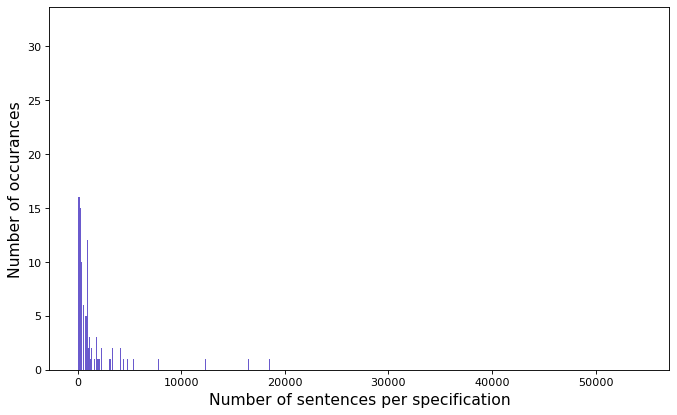

In [13]:
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(forPlot1[:,0], forPlot1[:,1], color='slateblue')
#plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
#plt.yticks([0,5,10,15,20,25])
plt.xlabel('Number of sentences per specification', fontsize = 14) 
plt.ylabel('Number of occurances',fontsize = 14)
plt.show()

In [14]:
line_per_spec_list = [key for key, val in dataProcessor.line_per_spec.items() for _ in range(val)]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


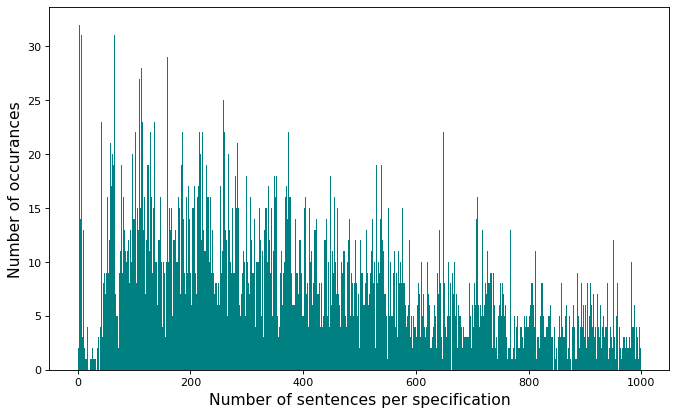

In [18]:
plt.figure(figsize=(10, 6), dpi=80)
line_per_spec_list = np.array(line_per_spec_list).astype(int)
binwidth = 1
#plt.hist(line_per_spec_list, bins=np.arange(0, len(line_per_spec_list) + binwidth, binwidth),  color = 'firebrick')
plt.hist(line_per_spec_list, bins=np.arange(0, 1000 + binwidth, binwidth),  color = 'teal')
#plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.yticks([0,5,10,15,20,25,30])
hfont = {'fontname':'Times New Roman'}
plt.xlabel('Number of sentences per specification', fontsize = 14, **hfont) 
plt.ylabel('Number of occurances',fontsize = 14, **hfont)
plt.show()

In [19]:
dataProcessor.spec_per_rel

{'Rel-11': 1214,
 'Rel-10': 1086,
 'Rel-9': 1106,
 'Rel-12': 1281,
 'Rel-16': 1367,
 'Rel-13': 1356,
 'Rel-18': 36,
 'Rel-19': 1,
 'Rel-8': 1093,
 'Rel-14': 1369,
 'Rel-17': 743,
 'Rel-15': 1601}

In [20]:
plot_dict = {}
for key, value in dataProcessor.spec_per_rel.items():
    newKey = int(key[4:])
    plot_dict[newKey] = value

In [22]:
forPlot2 = np.array(sorted(plot_dict.items()))

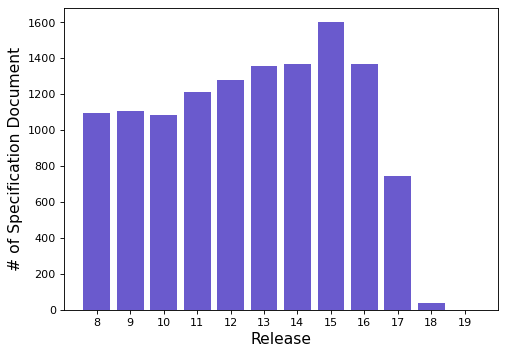

In [23]:
plt.figure(figsize=(7, 5), dpi=80)
plt.bar(forPlot2[:,0], forPlot2[:,1], color='slateblue')
hfont = {'fontname':'Times New Roman'}
plt.xlabel("Release", fontsize = 14, **hfont)
plt.ylabel("# of Specification Document", fontsize = 14, **hfont)
plt.xticks(forPlot2[:,0])
plt.show()

# Second step


In [24]:
token_count_vs_sent_count = {} #key: count of token in a sentence, value: number of sentences with that particular count
token_count = []
reduction_count = 0
with open('gold_5G_v5.txt', 'w') as out_file:
    with open(os.path.join(output_path,'processed_5G.txt')) as inp:
        lines = inp.readlines()
        key = 0
        for line in lines:
            if len(line.split())< 4 and line != '\n':
                reduction_count += 1
                continue
            line = re.sub(r' +', ' ', line)
            line = re.sub(r'^ +', '', line)
            if len(line.split()) > 4 and line[-2] != '.':
                line = line[:-2] + '.\n'
            if line[-5:] == 'e.g.\n' or line[-5:] == 'i.e.\n':
                line = line[:-2] + ' '
                reduction_count += 1
            if line == ' ':
                reduction_count += 1
                continue
            key += len(line.split())
            if len(line) > 1 and line[-1] == '\n': #end of a proper line, write in dictionary
                #print('hello')
                token_count.append(key)
                key = 0
#                 if key in token_count_vs_sent_count:
#                     token_count_vs_sent_count[key] += 1 #found another sentence with same count
#                     key = 0
#                 else:
#                     token_count_vs_sent_count[key] = 1 #found first sentence with this count
#                     key = 0
            out_file.write(line)
print("Number of line reduced: ", reduction_count)

Number of line reduced:  1215850


In [25]:
token_count_vs_sent_count

{}

In [ ]:
plt.bar(list(token_count_vs_sent_count.keys()), token_count_vs_sent_count.values(), color='g')
plt.show()

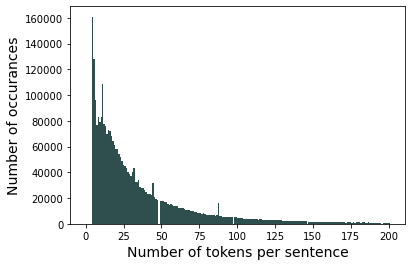

In [26]:
token_count = np.array(token_count).astype(int)
binwidth = 0.98
plt.hist(token_count, bins=np.arange(0, 200 + binwidth, binwidth), range = [0,200], color = 'darkslategray')
#plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xlabel('Number of tokens per sentence', fontsize = 14) 
plt.ylabel('Number of occurances',fontsize = 14)
plt.show()

In [29]:
viz_file1 = "./viz/sen_per_spec.npy"
viz_file2 = "./viz/doc_per_rel.npy"
viz_file3 = "./viz/tok_per_sen.npy"
with open(viz_file1, 'wb') as f:
    np.save(f, line_per_spec_list)

with open(viz_file2, 'wb') as f:
    np.save(f, forPlot2)

with open(viz_file3, 'wb') as f:
    np.save(f, token_count)
    
    

### Random Testing

In [ ]:
re.sub(r' +',' ','·         Periodic TAU: Upon the expiry of timer T3412, periodic TAU procedure is initiated to periodically notify the availability of the UE to the network')

In [ ]:
files = glob.glob(parent_path + '/**/*.txt', recursive=True)
files

In [ ]:
re.sub(r'([,;:])(\w)', r'\1 \2', 'Periodic TAU:Upon the expiry of timer T3412,periodic TAU procedure.Hello' )

In [ ]:
re.sub(r'[(\(\))(\[\])(\{\})]', '', 'Periodic TAU:Upon the expiry of timer T3412,periodic TAU procedure. () Hello {eh}')

In [ ]:
re.sub(r'(el)|(fo)', '', 'Periodic TAU:Upon the expiry of timer T3412, periodic TAU procedure.Hello elfo')

In [ ]:
re.sub(r'[el]', '', 'Periodic TAU:Upon the expiry of timer T3412, periodic TAU procedure.Hello elfo')

In [ ]:
re.sub(r'[\.:,;\-]*$', '', 'Per..iodic TAU:Upon th.e..;')

In [ ]:
'Per..iodic TAU:Upon th.e..;'+'.'

In [ ]:
print('\ue300')

In [ ]:
os.path.exists('gold_5G.txt')

In [ ]:
line = 'Periodic TAU:Upon the expiry of timer T3412,periodic TAU procedure. )() Hello {eh}'


In [ ]:
code_ident = ["((", "))", "{{", "}}",  "[[",  "]]",  "::", ":="]
if any(x in line for x in code_ident):
    print('hello')

In [ ]:
re.sub('Figure .*?[\dA-Za-z]:', '', 'Figure 3.1-1B: C: Examples of: ports for 3: BS F.1B: type 1-C and BS type 1-H')

In [ ]:
re.sub('\(see [fF]igure .*?\d\)', '', 'is the Transmission Bandwidth for kth allocated component carrier (see Figure 5.3.3-1) hello 5) (see Figure 5.3.3)')

In [ ]:
re.sub(r'\[\d*?\]', '', 'is the Transmission [5]Bandwidth [62] for kth [3] 4] allocated')

In [ ]:
re.sub(r'(\d[A-Za-z]*\.)*\d[\.\-]\d?', '', 'As shown in Figure 7V.3.2B.2.2-1, TS 24.301 transmission of section 4-1 Figure A-1 uplink frame Figure B.1.1.4.4-1 number [pic], Figure 7.3.2.2.2.1 hello')

In [ ]:
line = 'ahbda uadvb TS'
line[-2:]

In [ ]:
re.sub(r'^\d.*', '', '2 As shown in Figure 7V.3.2B.2.2-1, transmission of section 4-1 Figure A-1 uplink frame Figure B.1.1.4.4-1 number [pic], Figure 7.3.2.2.2.1 hello')

In [ ]:
'TS |TR |'

In [ ]:
re.sub(r'(\t)+', ' ', 'As shown in \t\tFigure \t')

In [ ]:
re.sub(r'\\x[0-9a-fA-F]{2}', '', r'As shown \xc0\xa1\x1e in \t\tFigure \t')

In [ ]:
'As shown\ in\t \\\xe0 Figure'

In [ ]:
re.sub(r'(\\)+', r'\\', 'As shown\ in\\t \\\xe0 Figure')

In [ ]:
re.sub(r'(\t)+', ' ', 'As shown in\\\t \\\ Figure')

In [ ]:
r1 = re.findall(r"^\w+", xx)

In [ ]:
len(re.search(r"\b[A-Z]*", 'HELLo me')[0])

In [ ]:
line = 'aEro Me'
line.istitle()

In [ ]:
sen = 'hello crow \\t'
if '\\' in sen:
    print('yes')

In [ ]:
re.sub(r' +', ' ', 'hello  \n   from the other side')

In [ ]:
re.sub(r'(\(\))|(\[\])|(\{\})', '', 'hello   (from) the other side' )

In [ ]:
a = 'hello . world '
a.split('. ')

In [ ]:
re.sub(r'(\d[A-Za-z]?\.)*\d[\.\-]\d?', '', 'section 4.3.2.1 says 3.2a that its 5.3a.2.2 3.1.d.e TS 24.301')

In [ ]:
if re.search(r'(C\(\d\d\d\))', "hello C(459)"):
    print("meh")

In [ ]:
r'(C\(\d\d\d\))' in "hello C(459)"

In [ ]:
if re.match(r'(C\(\d\d\d\))', 'hello C(123)'):
    print("hell")

In [ ]:
re.sub(r'(TS \d\d\d)|(TR \d\d\d)', 'specification document', 'TS 240 suggests')

In [ ]:
re.sub(r'^(TS \d\d\d)|^(TR \d\d\d)', 'Specification document', 'TS 240 suggests TR 341')

In [ ]:
re.search(r'% %', 'alu %% % % % potol')

In [ ]:
my = 'what the docu e.g.\n'
my[-5:]

In [ ]:
my =' degree  AOA_ANGLE _001 \(AOA_ANGLE < 1 degree  AOA_ANGLE _002 1 \(AOA_ANGLE < degree  AOA_ANGLE _717 35 \(AOA_ANGLE < 359 degre'
sum(c.isdigit() for c in my)/len(my)

In [ ]:
if '<img' in 'The overall presentation is governed by the SMIL file located as the primary item of "presentation.3gp" <region id="pics" left="0" width="176" height="144"/> <img region="pics" src="picjpg" dur="3s"/> <img region="pics" src="picjpg" dur="3s"/> <img region="pics" src="picjpg" dur="3s"/> The audio track resides in the Movie box and is referred to as "#box=moov" whereas the images are included as media files in the Meta box The following example consists of a DIMS presentation that refers to images, an AMR clip and scene updates.':
    print("hello")

In [ ]:
re.search(r'-?\d,? -?\d,? -?\d', '-a1, -1 1 1 1, 1 abcd efg')

In [ ]:
re.sub(r'(TS \d\d\d?)|(TR \d\d\d?)', 'Specification document', 'TS 24 suggests TR 341')

In [ ]:
"/scratch/gilbreth/rahman75/raw_data/Rel-10/21_series/21101-a40/21101-a40.txt".split('/')[5][:3]

In [ ]:
'/home/rahman75/Scrap/Dataset_L1/Data_4G/3glteinfo/ab.txt'.split('/')[-4]

In [ ]:
'/scratch/gilbreth/rahman75/raw_data/web_data/Cellular Dataset/eventhelix/ab.txt'.split('/')[5][:3]

In [ ]:
'\n\ta'.split()